# Sep 8th, 2021

**Motivation**: This was called play_lfr_final <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=False)

In [3]:
k = 8
p = 20
svinet = SVINET(mice, k, p, 'sub-SLC')
group_dir = get_svinet_group_dir(
    results_dir=mice.cfg.results_dir,
    k=k,
    p=p,
    graph_type=svinet_props.get('graph_type', 'real'),
)
print(group_dir)

current expt: 'p20'

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/gr
oup_results/real-p20-k8

## Load group results

In [4]:
available = [
    e for e in os.listdir(group_dir)
    if '(0.2,1.0;4)' in e
]
file = sorted(available, key=sort_date_latest)[-1]
print(file)

group_bins(0.2,1.0;4)_(2021_08_30).npy

In [5]:
group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

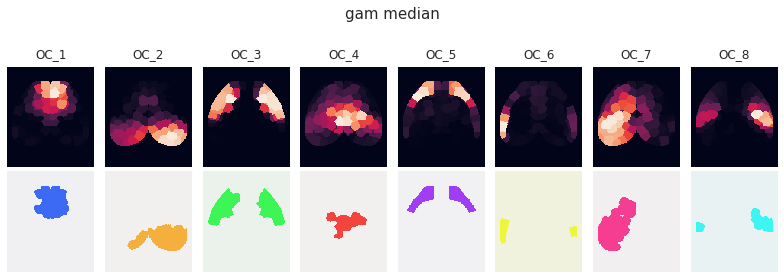

In [6]:
fig, axes = create_figure(2, k, (11, 3.8))

gam = np.median(group['gam_all'], 2)
gam = np.where(gam.sum(-2, keepdims=True) != 0, gam, np.nan)
gam = np.nanmean(np.nanmean(gam, 1), 0)
gam_arr = svinet.pi2arr(gam, cortex_only=True)

masks = svinet.masks_from_pi(gam, disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(k):
    im = axes[0, j].imshow(gam_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
fig.suptitle("gam median", fontsize=15, y=1.03)
p = 20
figs, sups = [], []
for k in range(3, 13):
    svinet = SVINET(mice, k, p, 'sub-SLC')
    group_dir = get_svinet_group_dir(
        results_dir=mice.cfg.results_dir,
        k=k,
        p=p,
        graph_type=svinet_props.get('graph_type', 'real'),
    )
    group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

    gam = np.median(group['gam_all'], 2)
    gam = np.where(gam.sum(-2, keepdims=True) != 0, gam, np.nan)
    gam = np.nanmean(np.nanmean(gam, 1), 0)
    pi = gam / gam.sum(0, keepdims=True)
    pi_arr = svinet.pi2arr(pi, cortex_only=True)
    mask = mice.parcel.results2d['parcel'].astype(bool)
    contour = mice.parcel.results2d.get('contour').astype(bool)
    trimmed = mice.parcel.trim_boundaries_2d(
        x={**pi_arr, 'contour': contour, 'mask': mask}, mask=mask)
    condition = np.logical_or(trimmed['contour'], np.invert(trimmed['mask']))
    oc_cortex = {
        idx: np.ma.masked_where(condition, trimmed[idx])
        for idx in range(1, k + 1)
    }

    disjoint_masks = svinet.masks_from_pi(gam, disjoint=True, cortex_only=True)
    disjoint_arr = {
        idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
        for idx, m in disjoint_masks.items()
    }
    disjoint_trimmed = mice.parcel.trim_boundaries_2d(x=disjoint_arr, mask=mask)
    disjoint = {
        idx: np.ma.masked_where(condition, disjoint_trimmed[idx])
        for idx in range(1, k + 1)
    }

    fig, axes = create_figure(2, k, (2 * k, 4.))
    for j in range(k):
        im = axes[0, j].imshow(oc_cortex[j + 1], cmap='rocket', vmin=0)
        axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
        _ = axes[1, j].imshow(disjoint[j + 1], cmap=svinet.cmaps[j + 1])
        axes[1, j].set_facecolor('#2d3938')

    remove_ticks(axes)
    sup = fig.suptitle(f"k = {k}", fontsize=15, y=1.01)
    figs.append(fig)
    sups.append(sup)
save_file = pjoin(tmp_dir, 'communities_all.pdf')
save_fig(figs, sups, save_file, multi=True, display=False)
print(save_file)plt.show()

In [8]:
p = 20
figs, sups = [], []
for k in tqdm(range(3, 13)):
    svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
    group_dir = get_svinet_group_dir(
        results_dir=mice.cfg.results_dir,
        k=k,
        p=p,
        graph_type=svinet_props.get('graph_type', 'real'),
    )
    group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

    gam = np.median(group['gam_all'], 2)
    gam = np.where(gam.sum(-2, keepdims=True) != 0, gam, np.nan)
    gam = np.nanmean(np.nanmean(gam, 1), 0)
    pi = gam / gam.sum(0, keepdims=True)
    pi_arr = svinet.pi2arr(pi, cortex_only=True)
    mask = mice.parcel.results2d['parcel'].astype(bool)
    contour = mice.parcel.results2d.get('contour').astype(bool)
    trimmed = mice.parcel.trim_boundaries_2d(
        x={**pi_arr, 'contour': contour, 'mask': mask}, mask=mask)
    condition = np.logical_or(trimmed['contour'], np.invert(trimmed['mask']))
    oc_cortex = {
        idx: np.ma.masked_where(condition, trimmed[idx])
        for idx in range(1, k + 1)
    }

    disjoint_masks = svinet.masks_from_pi(gam, disjoint=True, cortex_only=True)
    disjoint_arr = {
        idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
        for idx, m in disjoint_masks.items()
    }
    disjoint_trimmed = mice.parcel.trim_boundaries_2d(x=disjoint_arr, mask=mask)
    disjoint = {
        idx: np.ma.masked_where(condition, disjoint_trimmed[idx])
        for idx in range(1, k + 1)
    }

    fig, axes = create_figure(2, k, (2 * k, 4.))
    for j in range(k):
        im = axes[0, j].imshow(oc_cortex[j + 1], cmap='rocket', vmin=0)
        axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
        _ = axes[1, j].imshow(disjoint[j + 1], cmap=svinet.cmaps[j + 1])
        axes[1, j].set_facecolor('#2d3938')

    remove_ticks(axes)
    sup = fig.suptitle(f"k = {k}", fontsize=15, y=1.01)
    figs.append(fig)
    sups.append(sup)
save_file = pjoin(tmp_dir, 'communities_all.pdf')
save_fig(figs, sups, save_file, multi=True, display=False)
print(save_file)



p = 20
h_all = []
fig, axes = create_figure(2, 5, (13.5, 5.5))
for ii, k in tqdm(enumerate(range(3, 13))):
    svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
    group_dir = get_svinet_group_dir(
        results_dir=mice.cfg.results_dir,
        k=k,
        p=p,
        graph_type=svinet_props.get('graph_type', 'real'),
    )
    group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

    gam = np.median(group['gam_all'], 2)
    gam = np.where(gam.sum(-2, keepdims=True) != 0, gam, np.nan)
    gam = np.nanmean(np.nanmean(gam, 1), 0)
    eh = entropy_expect_beta(gam)
    # pi = gam / gam.sum(-2, keepdims=True)
    # h = sp_stats.entropy(pi, axis=-2) / np.log(k)
    # h_avg = np.nanmean(h, axis=0)
    h_all.append(np.expand_dims(eh, axis=0))
    h_mask = svinet.pi2arr(eh.reshape(1, -1), cortex_only=True)[1]
    
    mask = mice.parcel.results2d['parcel'].astype(bool)
    contour = mice.parcel.results2d.get('contour').astype(bool)
    trimmed = mice.parcel.trim_boundaries_2d(
        x={'h': h_mask, 'contour': contour, 'mask': mask}, mask=mask)
    condition = np.logical_or(trimmed['contour'], np.invert(trimmed['mask']))
    h_cortex = np.ma.masked_where(condition, trimmed['h'])
    
    ax = axes.ravel()[ii]
    im = ax.imshow(h_cortex, cmap='RdGy_r', vmin=0)
    ax.set_title(f"k = {k}", y=1.04)
    # ax.set_facecolor('#2d3938')

remove_ticks(axes)
sup = fig.suptitle('Node entropies for different num communities', fontsize=15, y=1.03)
save_file = pjoin(tmp_dir, 'entropies_all.pdf')
save_fig(fig, sup, save_file, multi=False, display=False)
print(save_file)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/communities_all.pdf

0it [00:00, ?it/s]

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/entropies_all.pdf

In [9]:
h_all = np.concatenate(h_all).mean(0)
h_all.shape

(138,)

<matplotlib.colorbar.Colorbar object at 0x7f2a8497e4c0>

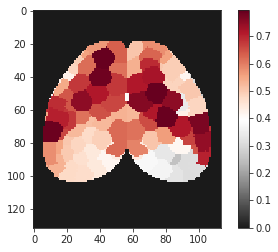

In [10]:
h_mask = svinet.pi2arr(h_all.reshape(1, -1), cortex_only=True)[1]
plt.imshow(h_mask, cmap='RdGy_r')
plt.colorbar()

## Save LFR graphs

### 1) make lfr flags

In [3]:
graphs = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        net = Network(
            mice=mice,
            key=key,
            percentiles=[20],
            **svinet_props,
        ).load_network()
        graphs[key] = net.graphs[20]

In [4]:
mu = 0.1
num_nodes = 138

num_n = 9
ons = [0]
ons += list(np.repeat(np.linspace(0, num_nodes, num_n, dtype=int)[1:-1], 3))
oms = [0]
oms += [2, 3, 4] * (num_n - 2)

for on, om in zip(ons, oms):
    name = [
        f"on{on}",
        f"om{om}",
        f"mu{mu}",
    ]
    name = '-'.join(name)
    mk_lfr(
        name=name,
        lfr_dir=lfr_dir,
        graphs=graphs,
        on=on,
        om=om,
    )

### 2) ./run_lfr.sh

run this in terminal

### 3) extract_true_k

In [5]:
extract_true_k(lfr_dir)

### 4) ./loop_svinet_lfr.sh

run this in terminal

### 5) done.

## Next: analyze

In [20]:
mu = 0.1
on, om = 86, 2
name = [
    f"on{on}",
    f"om{om}",
    f"mu{mu}",
]
name = '-'.join(name)
key = mice.get_key(2, 1)

lfr = load_lfr(
    load_dir=pjoin(lfr_dir, 'results', f"{name}_{key}"),
    weighted=False,
    hierarchical=False,
    random_state=mice.cfg.random_state,
)

Num true communities:   9
Num overlapping nodes:  86

<matplotlib.image.AxesImage object at 0x7f2a93af7580>

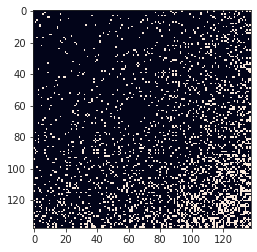

In [21]:
plt.imshow(lfr['a'])

In [22]:
lfr['membership']

{
    0: [3],
    1: [8],
    2: [5],
    3: [4],
    4: [6],
    5: [2],
    6: [1, 5],
    7: [8],
    8: [7],
    9: [3],
    10: [6],
    11: [2],
    12: [3, 7],
    13: [7],
    14: [1, 3],
    15: [6],
    16: [4, 5],
    17: [5],
    18: [6],
    19: [5],
    20: [2, 6],
    21: [0, 7],
    22: [2, 8],
    23: [0, 7],
    24: [5, 6],
    25: [3, 4],
    26: [2],
    27: [0],
    28: [4, 6],
    29: [7],
    30: [1, 6],
    31: [5, 8],
    32: [3, 4],
    33: [2, 3],
    34: [1, 7],
    35: [6],
    36: [6],
    37: [3, 4],
    38: [1, 8],
    39: [3, 4],
    40: [8],
    41: [0, 8],
    42: [4, 5],
    43: [1],
    44: [1],
    45: [6, 8],
    46: [2],
    47: [6, 7],
    48: [7],
    49: [1],
    50: [4, 6],
    51: [1, 5],
    52: [7],
    53: [4],
    54: [3, 5],
    55: [2, 8],
    56: [3],
    57: [4, 6],
    58: [6],
    59: [0, 3],
    60: [2],
    61: [5, 6],
    62: [2, 6],
    63: [4, 8],
    64: [1, 6],
    65: [1, 2],
    66: [6],
    67: [1],
    68: [3, 5],
    69: [1],
    70: [3],
    71: [4, 5],
    72: [2, 5],
    73: [0, 8],
    74: [5],
    75: [0, 6],
    76: [2, 3],
    77: [8],
    78: [2, 6],
    79: [4, 8],
    80: [7],
    81: [3, 4],
    82: [8],
    83: [4, 6],
    84: [1],
    85: [2, 5],
    86: [3],
    87: [1, 3],
    88: [8],
    89: [5],
    90: [8],
    91: [5, 6],
    92: [6, 7],
    93: [0, 2],
    94: [3, 6],
    95: [2, 6],
    96: [7],
    97: [1, 6],
    98: [0, 1],
    99: [4, 5],
    100: [6, 7],
    101: [1, 6],
    102: [6, 7],
    103: [1, 6],
    104: [2, 7],
    105: [1, 2],
    106: [5, 8],
    107: [6],
    108: [6],
    109: [0, 1],
    110: [3, 8],
    111: [0, 6],
    112: [2, 4],
    113: [3, 6],
    114: [3, 6],
    115: [0, 2],
    116: [1, 6],
    117: [2, 7],
    118: [6, 7],
    119: [1, 5],
    120: [3, 6],
    121: [5, 6],
    122: [5, 6],
    123: [6],
    124: [6],
    125: [2, 7],
    126: [5, 7],
    127: [5, 6],
    128: [3, 7],
    129: [6],
    130: [5, 8],
    131: [2, 6],
    132: [1, 6],
    133: [6],
    134: [6, 7],
    135: [1, 3],
    136: [1, 6],
    137: [1, 3]
}

In [23]:
{i: len(v) for i, v in lfr['community'].items()}

{0: 12, 1: 27, 2: 24, 3: 26, 4: 18, 5: 26, 6: 50, 7: 22, 8: 19}

In [7]:
lfr = compile_lfr_results(lfr_dir)

  0%|          | 0/660 [00:00<?, ?it/s]

In [18]:
lfr = np.load(pjoin(tmp_dir, 'lfr_compiled.npy'), allow_pickle=True).item()

In [26]:
num_nodes = 138
num_n = 9
ons = [0]
ons += list(np.repeat(np.linspace(0, num_nodes, num_n, dtype=int)[1:-1], 3))
oms = [0]
oms += [2, 3, 4] * (num_n - 2)

In [27]:
dlist = []
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        for on, om in zip(ons, oms):
            name = [
                f"on{on}",
                f"om{om}",
                f"mu{mu}",
            ]
            name = '-'.join(name)
            lfr = load_lfr(
                load_dir=pjoin(lfr_dir, 'results', f"{name}_{key}"),
                weighted=False,
                hierarchical=False,
                random_state=mice.cfg.random_state,
                verbose=False,
            )
            if on == 0:
                label = 'dosjoint'
            elif 0 < on <= 40:
                label = 'overlap-low'
            elif 40 < on <= 80:
                label = 'overlap-mid'
            elif 80 < on:
                label = 'overlap-high'
            
            dlist.append({
                'key': [key],
                'on': [on],
                'om': [om],
                'true_k': [len(lfr['community'])],
                'label': [label],
            })
df_lfr = pd.DataFrame(merge_dicts(dlist))

In [28]:
df_lfr.describe()

on 
 om 
 true_k 
 
 
 
 
 count 
 660.000000 
 660.000000 
 660.000000 
 
 
 mean 
 65.454545 
 2.863636 
 10.403030 
 
 
 std 
 36.572493 
 1.014109 
 4.260984 
 
 
 min 
 0.000000 
 0.000000 
 2.000000 
 
 
 25% 
 34.000000 
 2.000000 
 7.000000 
 
 
 50% 
 69.000000 
 3.000000 
 9.500000 
 
 
 75% 
 103.000000 
 4.000000 
 13.000000 
 
 
 max 
 120.000000 
 4.000000 
 24.000000

<AxesSubplot:xlabel='true_k', ylabel='Count'>

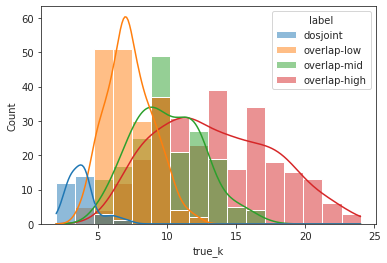

In [29]:
sns.histplot(data=df_lfr, x='true_k', hue='label', kde=True)

## New stuff

In [148]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score

In [149]:
lfr = np.load(pjoin(tmp_dir, 'lfr_compiled.npy'), allow_pickle=True).item()

In [150]:
thres = 0.8
dlist = []
for name, d in tqdm(lfr.items()):
    on, om, mu = tuple(map(lambda s: int(re.sub(r"\D", '', s)), name.split('-')))
    for key, _gam in d.items():
        # pred
        gam = np.median(_gam, 0)
        pi = gam / gam.sum(-2, keepdims=True)
        h = entropy_expect_beta(gam)
        pi_max = np.max(pi, axis=0)
        disjoint_pred = list(pi_max > thres)
        
        # true
        res = load_lfr(
            load_dir=pjoin(lfr_dir, 'results', f"{name}_{key}"),
            weighted=False,
            hierarchical=False,
            random_state=mice.cfg.random_state,
            verbose=False,
        )
        pi_true = np.zeros((len(res['community']), num_nodes))
        for node, mem in res['membership'].items():
            pi_true[:, node][mem] = 1.0 / len(mem)
        h_true = sp_stats.entropy(pi_true, axis=0) / np.log(len(pi_true))
        disjoint_true = [len(e) == 1 for e in res['membership'].values()]
        
        sim = dist2sim(sp_dist.cdist(pi_true, pi, metric='cosine'))
        mapping = find_best_match(sim)
        sim = sim[:, list(mapping.values())]
        
        _scores = {
            'pi_sim': np.diag(sim).mean(),
            'h_sim': sp_stats.spearmanr(h_true, h).correlation,
            'disjoint_f1': f1_score(disjoint_true, disjoint_pred),
            'disjoint_acc': accuracy_score(disjoint_true, disjoint_pred),
            'disjoint_mat': matthews_corrcoef(disjoint_true, disjoint_pred),
        }
        dlist.append({
            'on': [on] * len(_scores),
            'om': [om] * len(_scores),
            'mu': [mu] * len(_scores),
            'key': [key] * len(_scores),
            'label': _scores.keys(),
            'score': _scores.values(),
        })
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/22 [00:00<?, ?it/s]

<matplotlib.image.AxesImage object at 0x7f2a897ae550>

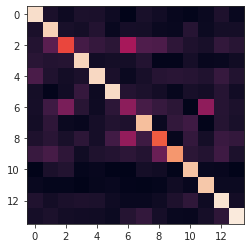

In [151]:
plt.imshow(sim)

<AxesSubplot:xlabel='score', ylabel='label'>

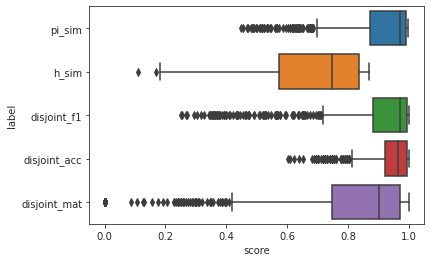

In [152]:
sns.boxplot(data=df, y='label', x='score')

<AxesSubplot:xlabel='score', ylabel='Density'>

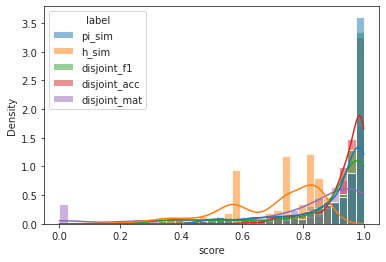

In [153]:
sns.histplot(data=df, x='score', hue='label', stat='density', kde=True)

Text(0.5, 1.0, 'spearman: 0.835')

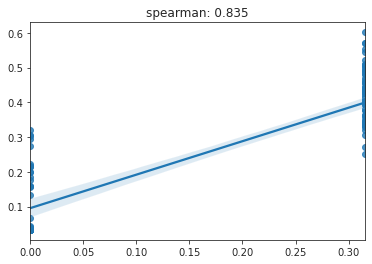

In [95]:
sns.regplot(h_true, h)
plt.title(f"spearman: {sp_stats.spearmanr(h_true, h).correlation:.3f}")

In [172]:
dlist = []
for name, d in tqdm(lfr.items()):
    on, om, mu = tuple(map(lambda s: int(re.sub(r"\D", '', s)), name.split('-')))
    for key, _gam in d.items():
        # true
        res = load_lfr(
            load_dir=pjoin(lfr_dir, 'results', f"{name}_{key}"),
            weighted=False,
            hierarchical=False,
            random_state=mice.cfg.random_state,
            verbose=False,
        )
        pi_true = np.zeros((len(res['community']), num_nodes))
        for node, mem in res['membership'].items():
            pi_true[:, node][mem] = 1.0 / len(mem)
        h_true = sp_stats.entropy(pi_true, axis=0) / np.log(len(pi_true))
        disjoint_true = [len(e) == 1 for e in res['membership'].values()]
        
        # pred
        gam = np.median(_gam, 0)
        pi = gam / gam.sum(-2, keepdims=True)
        h = entropy_expect_beta(gam)
        pi_max = np.max(pi, axis=0)

        for thres in [0.5, 0.6, 0.65, 0.7, 0.74, 0.76, 0.78, 0.8, 0.85, 0.9, 0.95]:
            disjoint_pred = list(pi_max > thres)
            _scores = {
                'disjoint_f1': f1_score(disjoint_true, disjoint_pred),
                'disjoint_acc': accuracy_score(disjoint_true, disjoint_pred),
               #  'disjoint_mat': matthews_corrcoef(disjoint_true, disjoint_pred),
            }
            dlist.append({
                'on': [on] * len(_scores),
                'om': [om] * len(_scores),
                'mu': [mu] * len(_scores),
                'key': [key] * len(_scores),
                'thres': [thres] * len(_scores),
                'label': _scores.keys(),
                'score': _scores.values(),
            })
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/22 [00:00<?, ?it/s]

<AxesSubplot:xlabel='score', ylabel='label'>

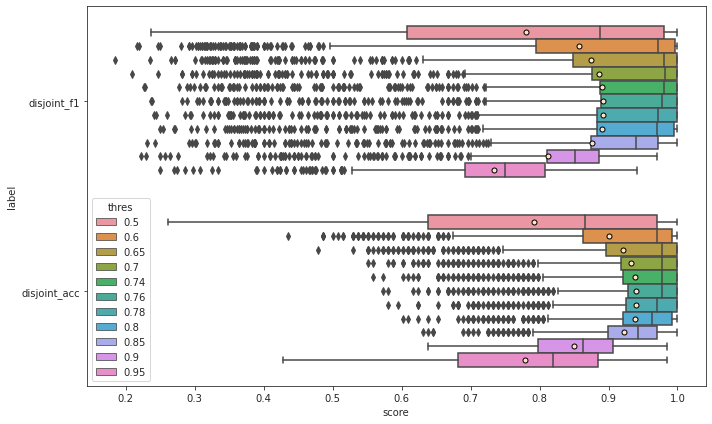

In [173]:
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": 5,
    "alpha": 1.0,
}

fig, ax = create_figure(1, 1, (10, 6)) 
sns.boxplot(
    data=df,
    y='label',
    x='score',
    hue='thres',
    showmeans=True,
    meanprops=meanprops,
    ax=ax,
)

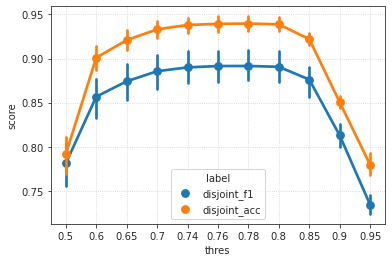

In [182]:
sns.pointplot(data=df, x='thres', y='score', hue='label', ci=99)
plt.grid()

In [183]:
_df = df.loc[df.thres == 0.8]
_df

on 
 om 
 mu 
 key 
 thres 
 label 
 score 
 
 
 
 
 14 
 0 
 0 
 1 
 sub-SLC01_ses-1 
 0.8 
 disjoint_f1 
 1.000000 
 
 
 15 
 0 
 0 
 1 
 sub-SLC01_ses-1 
 0.8 
 disjoint_acc 
 1.000000 
 
 
 36 
 0 
 0 
 1 
 sub-SLC01_ses-2 
 0.8 
 disjoint_f1 
 0.996364 
 
 
 37 
 0 
 0 
 1 
 sub-SLC01_ses-2 
 0.8 
 disjoint_acc 
 0.992754 
 
 
 58 
 0 
 0 
 1 
 sub-SLC01_ses-3 
 0.8 
 disjoint_f1 
 1.000000 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 14469 
 86 
 4 
 1 
 sub-SLC10_ses-1 
 0.8 
 disjoint_acc 
 0.876812 
 
 
 14490 
 86 
 4 
 1 
 sub-SLC10_ses-2 
 0.8 
 disjoint_f1 
 0.824561 
 
 
 14491 
 86 
 4 
 1 
 sub-SLC10_ses-2 
 0.8 
 disjoint_acc 
 0.855072 
 
 
 14512 
 86 
 4 
 1 
 sub-SLC10_ses-3 
 0.8 
 disjoint_f1 
 0.838095 
 
 
 14513 
 86 
 4 
 1 
 sub-SLC10_ses-3 
 0.8 
 disjoint_acc 
 0.876812 
 
 
 
 1320 rows × 7 columns

In [184]:
_df.score.argmin()

364

In [185]:
_df.iloc[[364]]

on 
 om 
 mu 
 key 
 thres 
 label 
 score 
 
 
 
 
 4018 
 120 
 4 
 1 
 sub-SLC01_ses-3 
 0.8 
 disjoint_f1 
 0.25

## OLD stuff

In [7]:
mu = 0.1
on, om = 0, 0
name = [
    f"on{on}",
    f"om{om}",
    f"mu{mu}",
]
name = '-'.join(name)
key = mice.get_key(2, 1)

In [8]:
lfr = load_lfr(
    load_dir=pjoin(lfr_dir, 'results', f"{name}_{key}"),
    weighted=False,
    hierarchical=False,
    random_state=mice.cfg.random_state,
    verbose=False,
)
true_k = len(lfr['community'])
true_k

4

In [26]:
os.listdir(pjoin(lfr_dir, 'results'))

[
    'on86-om2-mu0.1_sub-SLC02_ses-1',
    'on69-om3-mu0.1_sub-SLC09_ses-1',
    'on103-om2-mu0.1_sub-SLC04_ses-1',
    'on51-om4-mu0.1_sub-SLC10_ses-2',
    'on51-om3-mu0.1_sub-SLC05_ses-2',
    'on51-om3-mu0.1_sub-SLC04_ses-2',
    'on120-om4-mu0.1_sub-SLC05_ses-2',
    'on17-om4-mu0.1_sub-SLC09_ses-1',
    'on34-om2-mu0.1_sub-SLC06_ses-1',
    'on86-om4-mu0.1_sub-SLC10_ses-1',
    'on34-om2-mu0.1_sub-SLC09_ses-3',
    'on17-om2-mu0.1_sub-SLC04_ses-2',
    'on69-om2-mu0.1_sub-SLC03_ses-3',
    'on120-om3-mu0.1_sub-SLC08_ses-1',
    'on103-om4-mu0.1_sub-SLC05_ses-2',
    'on51-om4-mu0.1_sub-SLC05_ses-1',
    'on17-om3-mu0.1_sub-SLC10_ses-3',
    'on120-om2-mu0.1_sub-SLC02_ses-2',
    'on86-om2-mu0.1_sub-SLC04_ses-2',
    'on69-om3-mu0.1_sub-SLC03_ses-3',
    'on120-om4-mu0.1_sub-SLC08_ses-2',
    'on120-om4-mu0.1_sub-SLC02_ses-2',
    'on103-om4-mu0.1_sub-SLC08_ses-3',
    'on0-om0-mu0.1_sub-SLC06_ses-3',
    'on69-om3-mu0.1_sub-SLC08_ses-2',
    'on34-om2-mu0.1_sub-SLC04_ses-2',
    'on86-om3-mu0.1_sub-SLC08_ses-2',
    'on86-om4-mu0.1_sub-SLC10_ses-2',
    'on86-om3-mu0.1_sub-SLC07_ses-1',
    'on17-om3-mu0.1_sub-SLC04_ses-1',
    'on51-om3-mu0.1_sub-SLC01_ses-3',
    'on0-om0-mu0.1_sub-SLC07_ses-2',
    'on17-om2-mu0.1_sub-SLC10_ses-2',
    'on103-om4-mu0.1_sub-SLC02_ses-2',
    'on51-om2-mu0.1_sub-SLC02_ses-2',
    'on69-om4-mu0.1_sub-SLC10_ses-1',
    'on0-om0-mu0.1_sub-SLC03_ses-3',
    'on103-om4-mu0.1_sub-SLC10_ses-2',
    'on51-om4-mu0.1_sub-SLC02_ses-3',
    'on51-om2-mu0.1_sub-SLC09_ses-1',
    'on120-om4-mu0.1_sub-SLC10_ses-3',
    'on17-om4-mu0.1_sub-SLC06_ses-2',
    'on103-om3-mu0.1_sub-SLC08_ses-1',
    'on103-om4-mu0.1_sub-SLC05_ses-3',
    'on17-om4-mu0.1_sub-SLC02_ses-1',
    'on17-om4-mu0.1_sub-SLC04_ses-1',
    'on51-om3-mu0.1_sub-SLC10_ses-1',
    'on120-om3-mu0.1_sub-SLC07_ses-1',
    'on0-om0-mu0.1_sub-SLC02_ses-3',
    'on51-om4-mu0.1_sub-SLC09_ses-3',
    'on103-om2-mu0.1_sub-SLC03_ses-2',
    'on69-om3-mu0.1_sub-SLC10_ses-2',
    'on34-om4-mu0.1_sub-SLC08_ses-3',
    'on69-om3-mu0.1_sub-SLC06_ses-2',
    'on103-om4-mu0.1_sub-SLC09_ses-1',
    'on51-om2-mu0.1_sub-SLC06_ses-1',
    'on69-om4-mu0.1_sub-SLC06_ses-1',
    'on51-om4-mu0.1_sub-SLC06_ses-2',
    'on34-om3-mu0.1_sub-SLC04_ses-2',
    'on120-om4-mu0.1_sub-SLC06_ses-2',
    'on34-om4-mu0.1_sub-SLC07_ses-1',
    'on103-om4-mu0.1_sub-SLC03_ses-1',
    'on51-om2-mu0.1_sub-SLC07_ses-2',
    'on120-om2-mu0.1_sub-SLC08_ses-1',
    'on120-om3-mu0.1_sub-SLC08_ses-3',
    'on17-om4-mu0.1_sub-SLC07_ses-1',
    'on51-om3-mu0.1_sub-SLC06_ses-1',
    'on86-om3-mu0.1_sub-SLC08_ses-3',
    'on86-om2-mu0.1_sub-SLC05_ses-1',
    'on51-om2-mu0.1_sub-SLC10_ses-1',
    'on103-om2-mu0.1_sub-SLC10_ses-2',
    'on17-om4-mu0.1_sub-SLC01_ses-3',
    'on51-om4-mu0.1_sub-SLC07_ses-3',
    'on17-om2-mu0.1_sub-SLC08_ses-2',
    'on0-om0-mu0.1_sub-SLC07_ses-3',
    'on103-om3-mu0.1_sub-SLC09_ses-1',
    'on34-om4-mu0.1_sub-SLC05_ses-1',
    'on17-om2-mu0.1_sub-SLC03_ses-2',
    'on17-om3-mu0.1_sub-SLC08_ses-1',
    'on120-om4-mu0.1_sub-SLC02_ses-1',
    'on86-om4-mu0.1_sub-SLC07_ses-1',
    'on120-om2-mu0.1_sub-SLC04_ses-2',
    'on86-om4-mu0.1_sub-SLC03_ses-3',
    'on69-om3-mu0.1_sub-SLC08_ses-1',
    'on86-om3-mu0.1_sub-SLC10_ses-2',
    'on34-om2-mu0.1_sub-SLC05_ses-3',
    'on103-om3-mu0.1_sub-SLC10_ses-1',
    'on0-om0-mu0.1_sub-SLC07_ses-1',
    'on86-om3-mu0.1_sub-SLC07_ses-2',
    'on17-om2-mu0.1_sub-SLC07_ses-3',
    'on86-om2-mu0.1_sub-SLC01_ses-3',
    'on86-om4-mu0.1_sub-SLC07_ses-3',
    'on69-om4-mu0.1_sub-SLC10_ses-3',
    'on17-om2-mu0.1_sub-SLC06_ses-2',
    'on69-om2-mu0.1_sub-SLC08_ses-2',
    'on69-om3-mu0.1_sub-SLC03_ses-1',
    'on17-om4-mu0.1_sub-SLC05_ses-1',
    'on86-om2-mu0.1_sub-SLC08_ses-1',
    'on103-om2-mu0.1_sub-SLC02_ses-2',
    'on51-om3-mu0.1_sub-SLC05_ses-1',
    'on86-om3-mu0.1_sub-SLC02_ses-3',
    'on103-om3-mu0.1_sub-SLC05_ses-1',
    'on120-om4-mu0.1_sub-SLC09_ses-3',
    'on120-om3-mu0.1_sub-SLC06_ses-3',
    'on120-om3-mu0.1_su

In [9]:
path = pjoin(lfr_dir, 'results', f"{name}_{key}")
runs = next(os.walk(path))[1]
runs = sorted(runs, key=seed_sort_fn)

_runs = {}
for run_name in runs:
    if f"k{true_k}" not in run_name or 'linksampling' not in run_name:
        continue
    num_nodes = re.sub(r"\D", "", run_name.split('-')[0])
    num_nodes = int(num_nodes)
    try:
        _runs[run_name] = load_svinet_runs(
            path=pjoin(path, run_name),
            true_nodes=range(1, num_nodes + 1),
        )
    except FileNotFoundError:
        continue

In [10]:
num_nodes = 138

gam_all = np.zeros((len(_runs), true_k, num_nodes))
for i, run in enumerate(_runs.values()):
    try:
        gam_all[i] = run['gam']
    except ValueError:
        gam_all[i] = run['gam'][:true_k]

centroids, _ = fit_kmeans(
    data=gam_all.reshape(-1, num_nodes),
    n_clusters=true_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
    normalize=True,
    verbose=True,
)
perms = find_best_mappings(
    centroids=Normalizer('l2').fit_transform(centroids),
    data={
        i: Normalizer('l2').fit_transform(gam_all[i])
        for i in range(len(gam_all))},
    match_metric='euclidean',
    global_order=True,
)
a, b = [], []
for i, mapping in perms.items():
    a += [i] * true_k
    b += list(mapping.values())
gam_all = gam_all[a, b].reshape(gam_all.shape)
gam = gam_all.mean(0)
gam.shape, gam_all.shape

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

((4, 138), (100, 4, 138))

In [11]:
scores = np.zeros((len(_runs), true_k))

for i in range(len(gam_all)):
    d = sp_dist.cdist(gam, gam_all[i], metric='cosine')
    scores[i] = np.diag(dist2sim(d))

scores.shape, scores.mean(0), np.median(scores, 0)

(
    (100, 4),
    array([0.97502012, 0.97562975, 0.98501804, 0.81575794]),
    array([0.99781311, 0.99514524, 0.99831347, 0.97476212])
)

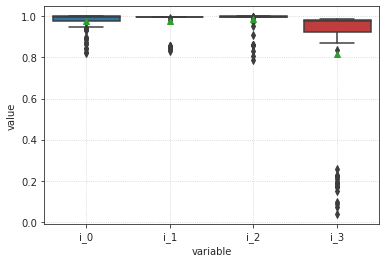

In [12]:
_df = pd.DataFrame({f"i_{i}": list(scores[:, i]) for i in range(true_k)}).melt()
sns.boxplot(data=_df, x='variable', y='value', showmeans=True)
plt.grid()

{0: 2, 1: 1, 2: 0, 3: 3}

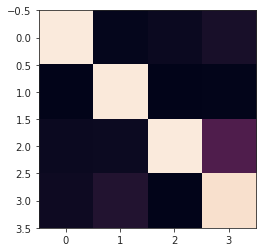

In [13]:
pi = gam / gam.sum(0, keepdims=True)

true_pi = np.zeros((true_k, num_nodes))
for comm_i, comm_list in lfr['community'].items():
    true_pi[comm_i][comm_list] = 1.0

d = sp_dist.cdist(true_pi, pi, metric='cosine')
s = dist2sim(d)

true_mapping = find_best_match(s, reverse=True, global_order=True)
pi = pi[list(true_mapping.values())]
s = s[:, list(true_mapping.values())]

plt.imshow(s)
true_mapping

In [14]:
np.diag(s)

array([0.99681967, 0.9919069 , 0.99734071, 0.96869882])

In [159]:
for node in range(num_nodes):
    test = pi_synth_avg[:, node] > 0.8
    if not any(test):
        print(node, np.round(pi_synth_avg[:, node], 3))

2 [0.01  0.036 0.433 0.011 0.462 0.039 0.009]

4 [0.418 0.004 0.025 0.002 0.122 0.42  0.008]

5 [0.011 0.007 0.739 0.025 0.028 0.099 0.092]

7 [0.006 0.002 0.013 0.003 0.431 0.445 0.099]

9 [0.019 0.694 0.099 0.139 0.003 0.038 0.007]

10 [0.133 0.36  0.053 0.414 0.009 0.02  0.01 ]

14 [0.52  0.011 0.308 0.005 0.124 0.028 0.003]

15 [0.018 0.719 0.096 0.031 0.003 0.039 0.093]

17 [0.01  0.729 0.109 0.09  0.002 0.036 0.025]

18 [0.012 0.004 0.482 0.013 0.418 0.058 0.012]

19 [0.485 0.324 0.06  0.018 0.008 0.014 0.09 ]

20 [0.051 0.007 0.488 0.364 0.021 0.054 0.014]

21 [0.128 0.412 0.051 0.374 0.006 0.019 0.01 ]

23 [0.014 0.121 0.037 0.792 0.018 0.015 0.003]

26 [0.439 0.386 0.056 0.015 0.006 0.01  0.089]

29 [0.033 0.01  0.79  0.028 0.028 0.097 0.014]

30 [0.011 0.005 0.778 0.029 0.028 0.1   0.05 ]

31 [0.002 0.002 0.021 0.002 0.192 0.008 0.773]

32 [0.015 0.739 0.093 0.034 0.003 0.036 0.08 ]

34 [0.301 0.002 0.032 0.002 0.012 0.145 0.505]

35 [0.014 0.37  0.047 0.233 0.002 0.009 0.325]

37 [0.011 0.032 0.791 0.024 0.026 0.096 0.02 ]

40 [0.077 0.006 0.02  0.08  0.015 0.031 0.771]

41 [0.01  0.017 0.756 0.025 0.094 0.083 0.014]

55 [0.419 0.007 0.06  0.035 0.475 0.002 0.002]

56 [0.011 0.004 0.781 0.019 0.03  0.112 0.044]

63 [0.009 0.71  0.105 0.082 0.002 0.085 0.006]

69 [0.006 0.688 0.124 0.143 0.002 0.031 0.005]

72 [0.013 0.743 0.108 0.036 0.002 0.084 0.014]

73 [0.073 0.717 0.118 0.03  0.003 0.038 0.021]

76 [0.05  0.744 0.116 0.04  0.002 0.039 0.01 ]

77 [0.014 0.681 0.186 0.073 0.007 0.034 0.006]

82 [0.006 0.016 0.014 0.445 0.01  0.019 0.489]

83 [0.012 0.014 0.39  0.459 0.022 0.051 0.052]

84 [0.013 0.694 0.12  0.034 0.003 0.115 0.021]

86 [0.018 0.004 0.778 0.023 0.03  0.127 0.02 ]

87 [0.103 0.706 0.102 0.036 0.002 0.039 0.011]

88 [0.018 0.731 0.108 0.044 0.002 0.089 0.009]

91 [0.009 0.004 0.412 0.024 0.021 0.517 0.013]

93 [0.012 0.763 0.11  0.035 0.003 0.05  0.027]

95 [0.025 0.005 0.781 0.022 0.03  0.119 0.018]

97 [0.011 0.369 0.039 0.013 0.012 0.486 0.069]

103 [0.012 0.723 0.163 0.059 0.002 0.035 0.005]

104 [0.011 0.035 0.015 0.466 0.019 0.427 0.028]

106 [0.002 0.012 0.021 0.003 0.058 0.434 0.469]

107 [0.378 0.01  0.038 0.003 0.013 0.486 0.072]

109 [0.007 0.009 0.427 0.014 0.025 0.093 0.425]

110 [0.007 0.008 0.454 0.049 0.021 0.45  0.011]

114 [0.014 0.737 0.102 0.084 0.002 0.047 0.013]

119 [0.398 0.041 0.026 0.01  0.007 0.05  0.468]

121 [0.021 0.382 0.056 0.02  0.01  0.485 0.027]

122 [0.023 0.718 0.115 0.044 0.002 0.089 0.008]

123 [0.003 0.061 0.026 0.005 0.016 0.422 0.466]

124 [0.015 0.736 0.121 0.035 0.028 0.036 0.029]

125 [0.064 0.009 0.41  0.426 0.023 0.057 0.01 ]

126 [0.037 0.699 0.1   0.12  0.002 0.033 0.01 ]

127 [0.016 0.722 0.121 0.033 0.003 0.038 0.066]

128 [0.023 0.733 0.1   0.068 0.019 0.036 0.021]

129 [0.016 0.719 0.11  0.061 0.003 0.084 0.007]

130 [0.002 0.014 0.039 0.003 0.017 0.487 0.438]

131 [0.01  0.38  0.055 0.077 0.033 0.025 0.419]

132 [0.452 0.035 0.032 0.442 0.025 0.008 0.006]

133 [0.007 0.382 0.463 0.032 0.043 0.059 0.014]

134 [0.011 0.007 0.013 0.02  0.489 0.01  0.45 ]

135 [0.414 0.014 0.065 0.47  0.022 0.01  0.005]

136 [0.014 0.026 0.019 0.474 0.027 0.011 0.429]

137 [0.013 0.385 0.448 0.027 0.013 0.105 0.01 ]

<AxesSubplot:ylabel='Density'>

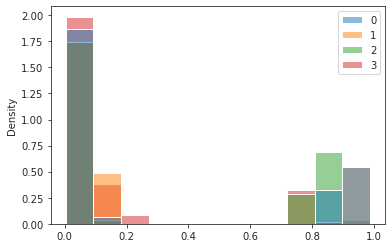

In [15]:
sns.histplot(
    {i: pi[i] for i in range(true_k)},
    # bins=bins,
    alpha=0.5,
    stat='density',
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

In [ ]:
list(lfr)

In [16]:
pi_all = gam_all / gam_all.sum(1, keepdims=1)
pi_all.shape

(100, 4, 138)

In [23]:
%%time

num_cuts = 16
bins = np.linspace(0.2, 1., num_cuts + 1)
intervals = pd.cut([], bins).value_counts().index

cut_oc, cut_nodes = cut_data(pi_all, bins)
cut_oc.shape, cut_nodes.shape

CPU times: user 220 ms, sys: 3.65 ms, total: 223 ms
Wall time: 221 ms


((100, 4, 16), (100, 138, 16))

In [24]:
bins

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

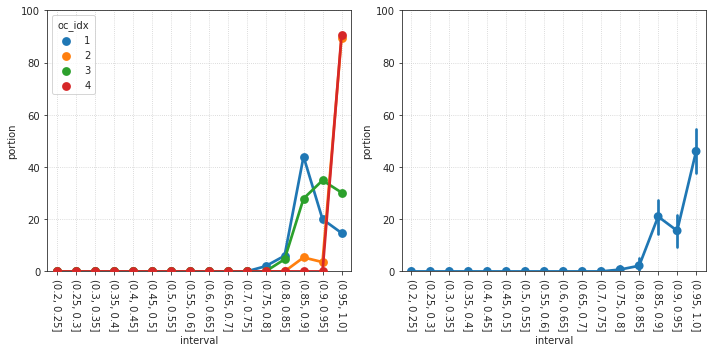

In [25]:
cut_oc_median = np.median(cut_oc, axis=0)
cut_nodes_median = np.median(cut_nodes, axis=0)

dlist = []
for j, intvl in enumerate(intervals):
    for i in range(true_k):
        dlist.append({
            'oc_idx': [i + 1],
            'interval': [intvl],
            'portion': [cut_oc_median[i, j]],
            'label': ['oc'], 
        })
df_oc = pd.DataFrame(merge_dicts(dlist))

dlist = []
for j, intvl in enumerate(intervals):
    for i in range(num_nodes):
        dlist.append({
            'node': [i],
            'interval': [intvl],
            'portion': [cut_nodes_median[i, j]],
            'label': ['nodes'], 
        })
df_nodes = pd.DataFrame(merge_dicts(dlist))

fig, axes = create_figure(1, 2, (10, 5))

for i, ax in enumerate(axes.ravel()):
    sns.pointplot(
        data=df_oc if i == 0 else df_nodes,
        x='interval',
        y='portion',
        hue='oc_idx' if i == 0 else None,
        ax=ax,
    )
    ax.tick_params(axis='x', rotation=-90)
    ax.set_ylim(0, 100)
    ax.grid()

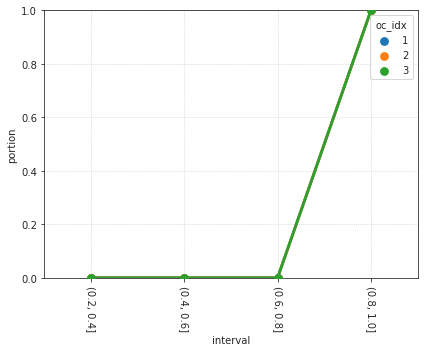

In [473]:
dlist = []
for i in range(true_k):
    for j, intvl in enumerate(intervals):
        dlist.append({
            'oc_idx': [i + 1] * len(cut_oc),
            'interval': [intvl] * len(cut_oc),
            'portion': cut_oc[:, i, j],
        })

fig, ax = create_figure(1, 1, (6, 5))
_df = pd.DataFrame(merge_dicts(dlist))
sns.pointplot(
    data=_df,
    x='interval',
    y='portion',
    hue='oc_idx',
    ax=ax,
)
ax.tick_params(axis='x', rotation=-90)
ax.set_ylim(0, 1)
ax.grid()

In [474]:
beta = run['lam'][:, 0] / (run['lam'][:, 0] + run['lam'][:, 1])
beta_diag = np.zeros((true_k, true_k))
np.fill_diagonal(beta_diag, beta)

In [475]:
y = pi_synth_avg.T @ beta_diag @ pi_synth_avg
y.shape

(138, 138)

<matplotlib.colorbar.Colorbar object at 0x7f97d864b7f0>

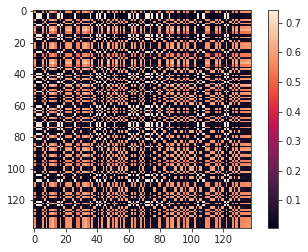

In [538]:
plt.imshow(y)
plt.colorbar()

In [477]:
n_clusters = 6

comps, model = fit_kmeans(
    data=y,
    n_clusters=n_clusters,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
    normalize=True,
    verbose=True,
)
comps /= comps.sum(0, keepdims=True)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

<AxesSubplot:ylabel='Count'>

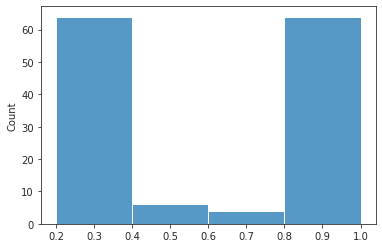

In [478]:
h = sp_stats.entropy(comps, axis=0) / np.log(n_clusters)
sns.histplot(h, bins=bins)

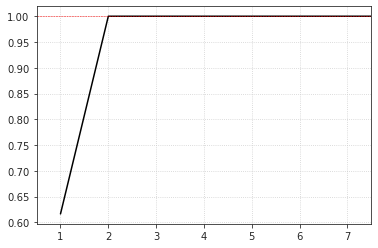

In [479]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, svd_solver='full', random_state=0).fit(y)
data2plt = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(data2plt) + 1), data2plt, color='k')
plt.axhline(1.0, color='r', ls='--', lw=0.5)
plt.xlim(0.5, 7.5)
plt.grid()

<matplotlib.image.AxesImage object at 0x7f97db416670>

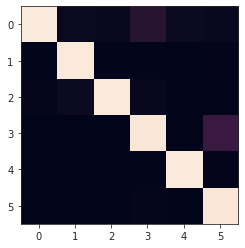

In [267]:
np.diag(s)

array([0.99776273, 0.99691402, 0.99851813, 0.98530833, 0.99814875,
       0.98572866])

In [9]:
ons, oms

([0, 34, 34, 69, 69, 103, 103], [0, 2, 4, 2, 5, 2, 7])

## Disgraceful for loop

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.90928903 0.92990253 0.98067461 0.97977179 0.96993086 0.92696345
 0.73474289 0.85829982] [0.94622398 0.99239127 0.99394049 0.99658777 0.99444519 0.98318481
 0.97664027 0.98505021]

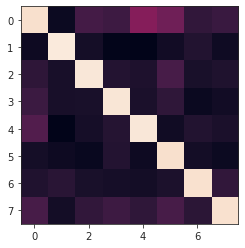

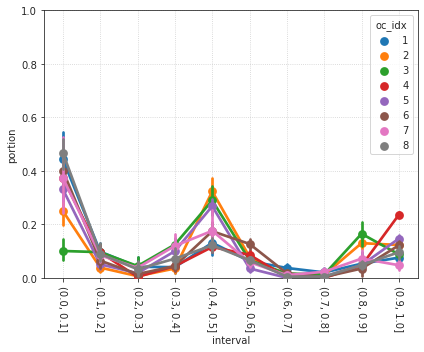

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.94004032 0.99215361 0.99448474 0.96730181 0.94776029 0.93633495
 0.90064311 0.90430341 0.54080725] [0.97953919 0.99569636 0.99692027 0.99352326 0.98491294 
0.98788777
 0.95780885 0.98270564 0.48355942]

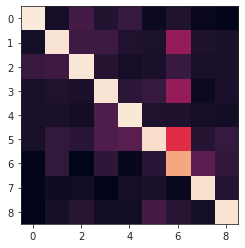

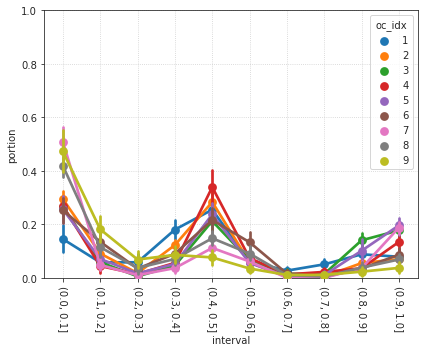

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.9916009  0.95399092 0.98221132 0.94655532 0.99273236 0.93198162
 0.64611133] [0.99554317 0.98390957 0.99591792 0.96578043 0.99744022 0.93725884
 0.639545  ]

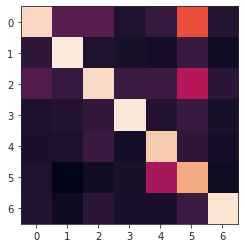

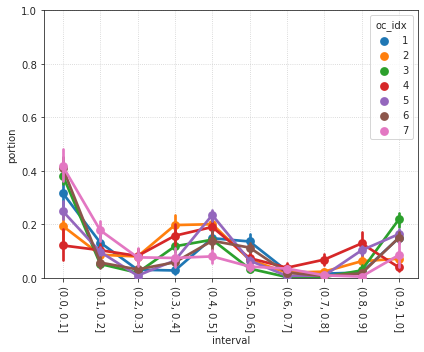

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96910311 0.95015222 0.91052797 0.8328588  0.8241972  0.94594571
 0.82877203 0.65100358] [0.99012105 0.98800668 0.94816767 0.8388937  0.94652405 0.97555671
 0.953575   0.88119252]

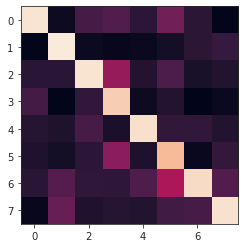

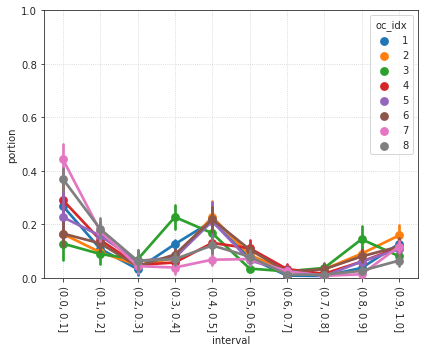

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98521539 0.98212317 0.99455465 0.98863207 0.97716173 0.99460219] [0.99633353 
0.99645946 0.99769172 0.99497101 0.99251099 0.99744986]

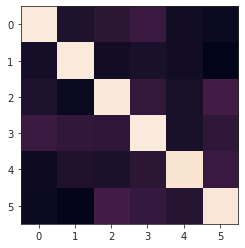

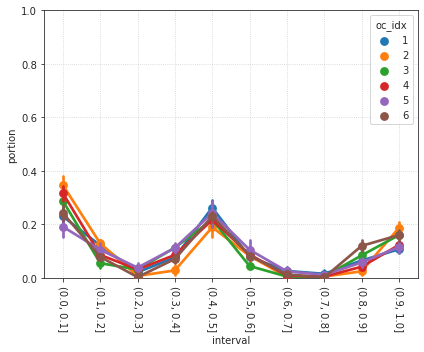

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92210704 0.83177285 0.89180732 0.84752369 0.97322173 0.90364943
 0.88161251 0.68097378 0.63875157] [0.92490226 0.85299537 0.98110047 0.97859689 0.97951012 
0.97701795
 0.98375644 0.89865168 0.95004713]

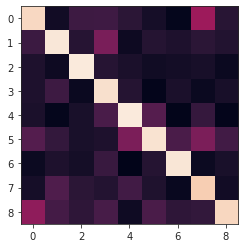

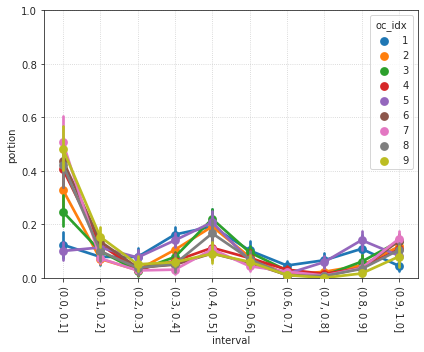

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.91502643 0.9323611  0.89945128 0.77886415 0.94287208 0.98690583
 0.81106867 0.67645874 0.61038158] [0.96513782 0.97019014 0.94510267 0.82699111 0.95819519 
0.99606434
 0.98701753 0.82639727 0.57883017]

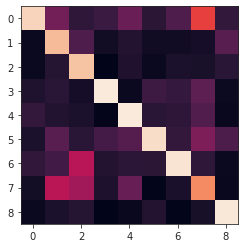

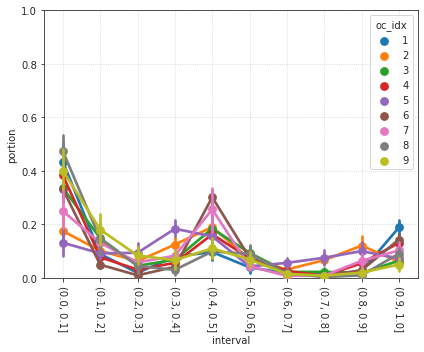

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98464786 0.83795232 0.81414208 0.97228041 0.98012778 0.92244986
 0.66867673] [0.9941458  0.82726727 0.92910771 0.98540146 0.98874589 0.9938252
 0.92904118]

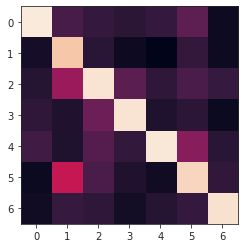

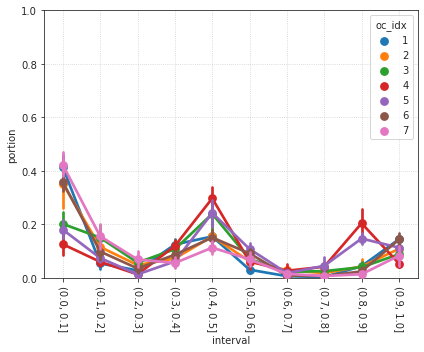

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.91857727 0.97391422 0.94522968 0.96326234 0.95898758 0.97299291
 0.84804061 0.68883091 0.78577632] [0.96757204 0.99780655 0.97150701 0.9884055  0.99135278 
0.98788614
 0.90111482 0.96856539 0.9747604 ]

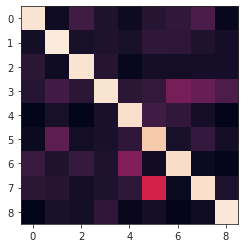

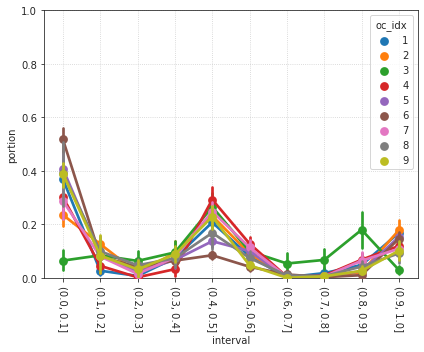

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98720993 0.96267157 0.95539619 0.95011895 0.98095766 0.96193336
 0.83876472 0.964813   0.96381886 0.84604115 0.45665784] [0.99758504 0.98891704 0.98324283 
0.9917138  0.99442806 0.99489176
 0.97165767 0.98874108 0.99626226 0.9424932  0.3153531 ]

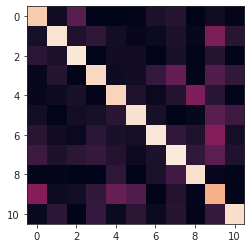

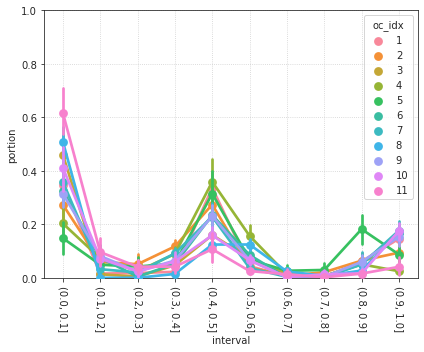

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.9469448  0.92056145 0.93310641 0.83380999 0.92283944 0.77488143
 0.60943093 0.99341717] [0.97573579 0.94334516 0.9838324  0.90941291 0.98593717 0.83129538
 0.63881657 0.99514063]

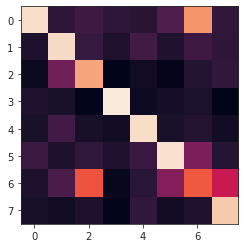

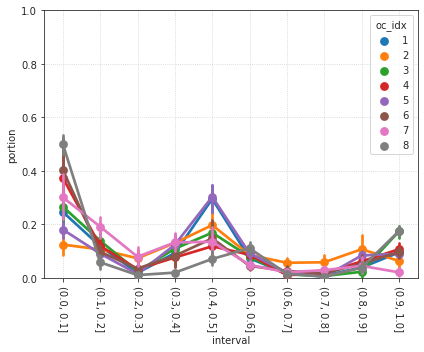

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96244845 0.98121535 0.95623995 0.91145591 0.99755884 0.79116005
 0.88776622] [0.99255082 0.9948841  0.99075264 0.95231674 0.99937467 0.96888924
 0.98334975]

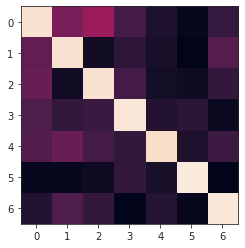

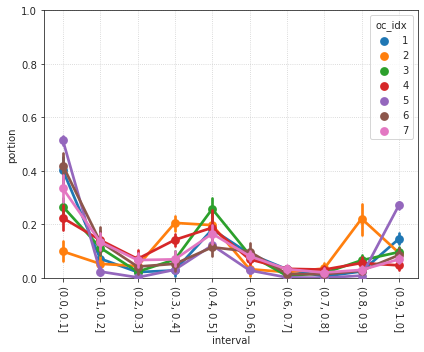

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93827292 0.89586758 0.91699627 0.95229581 0.71041504 0.62499023
 0.78747118] [0.94548035 0.91754857 0.9667154  0.98630194 0.86265349 0.66934006
 0.97321448]

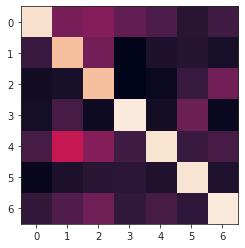

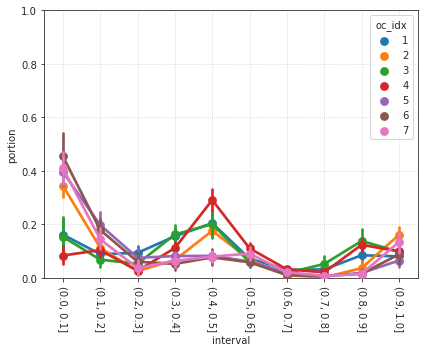

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.89571974 0.90025089 0.94417027 0.90243805 0.97348495 0.70905837
 0.62396666 0.65053931] [0.92646395 0.92644731 0.98102825 0.97348541 0.98942476 0.80182868
 0.83738319 0.87359791]

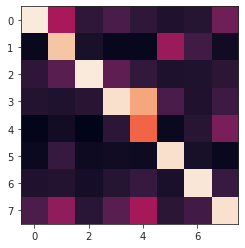

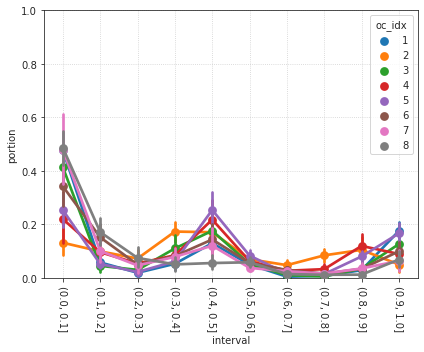

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.82930341 0.97804766 0.94827031 0.9174025  0.89781383 0.80777254
 0.64766225] [0.82448346 0.985945   0.98361801 0.97783082 0.92604833 0.93732591
 0.64609144]

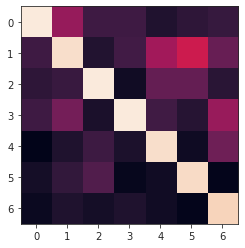

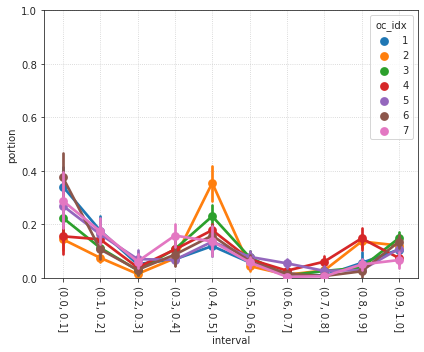

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.84905068 0.88970045 0.86029915 0.87290613 0.90244218 0.9277359
 0.6887055 ] [0.83654959 0.97230014 0.93567848 0.94850016 0.94325396 0.9910518
 0.92650571]

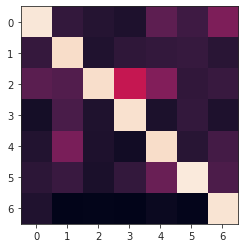

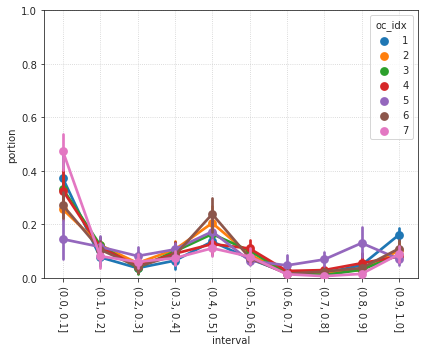

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96357389 0.90354614 0.96057599 0.81800916 0.99056432 0.81561324
 0.852735   0.6317824 ] [0.98959299 0.95799118 0.97143182 0.91743285 0.99748435 0.98806641
 0.95402369 0.79081153]

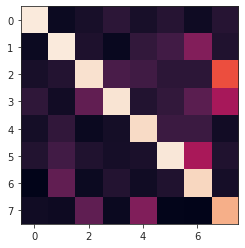

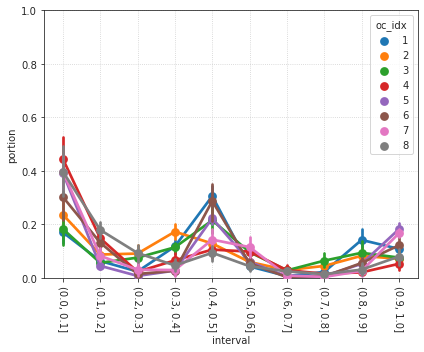

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93711205 0.96674349 0.91407612 0.76465579 0.96230672 0.64856014
 0.77006381 0.65740049] [0.98888034 0.98627847 0.93061532 0.81608838 0.98202044 0.87024072
 0.88797227 0.75621482]

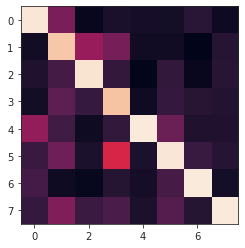

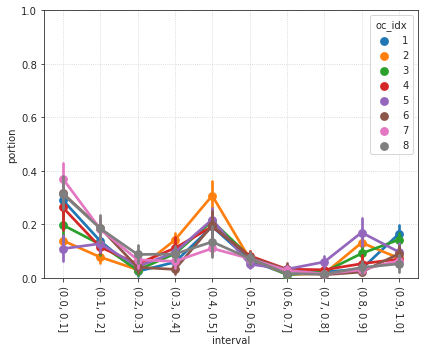

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98822104 0.9165969  0.96319176 0.93158954 0.9935046  0.99489548
 0.98825191 0.79722532 0.74345433] [0.99413819 0.96504058 0.9889455  0.9961925  0.99831084 
0.99643225
 0.99602821 0.94228509 0.98726225]

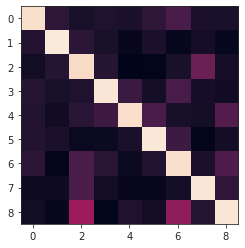

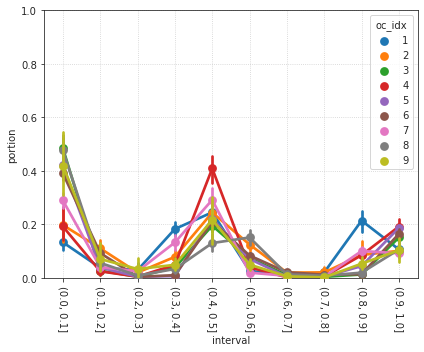

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.99249702 0.97168091 0.97459727 0.99655322 0.92513489 0.6913314 ] [0.99510443 
0.98741225 0.99037429 0.9978438  0.93546238 0.93003501]

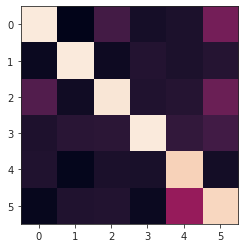

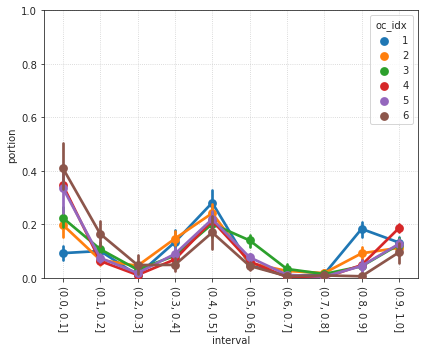

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.99360219 0.99173801 0.98656761 0.97313997 0.94219802 0.99806513
 0.84457699 0.97617248 0.74003635] [0.99694562 0.99576357 0.99738796 0.99482342 0.97035948 
0.99830825
 0.9610525  0.99104754 0.95652511]

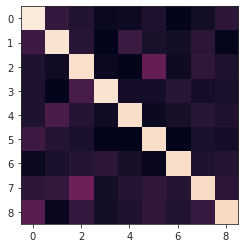

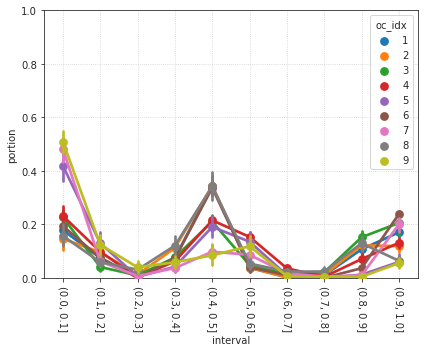

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.87051631 0.96269494 0.96206607 0.97807129 0.94087726 0.81459906
 0.88998847 0.99311924 0.6934108  0.56289958] [0.88403016 0.98380348 0.9930393  0.99626027 
0.97809832 0.88000655
 0.92960519 0.99785314 0.78988443 0.50216961]

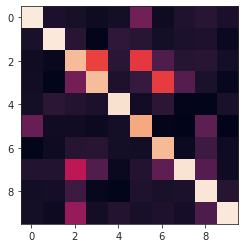

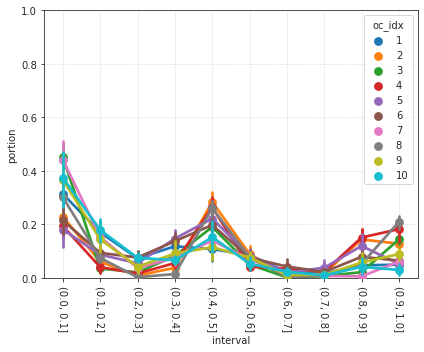

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96504391 0.97097441 0.93251533 0.95395003 0.90968721 0.6362302 ] [0.98656614 
0.99376721 0.96483605 0.96973663 0.95857804 0.60729543]

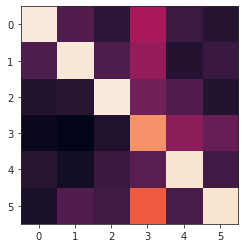

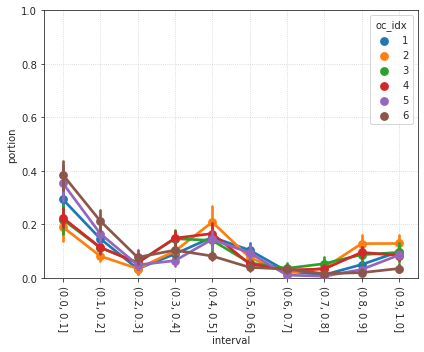

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.99157822 0.97226741 0.94626583 0.96713015 0.96459049 0.73185615
 0.83035709] [0.99744944 0.98569994 0.97015697 0.98969674 0.98362352 0.94069343
 0.9927293 ]

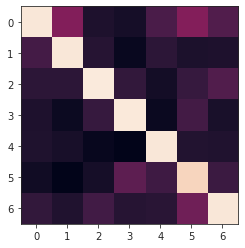

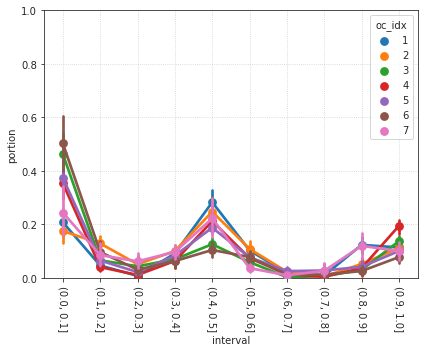

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92911645 0.902821   0.88231586 0.9800875  0.89952839 0.99312673
 0.89535595 0.67973944] [0.94417395 0.96434873 0.95869502 0.98558235 0.96866171 0.99703543
 0.9443616  0.90722622]

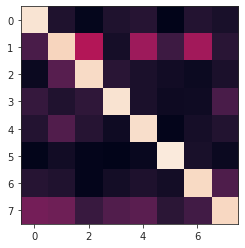

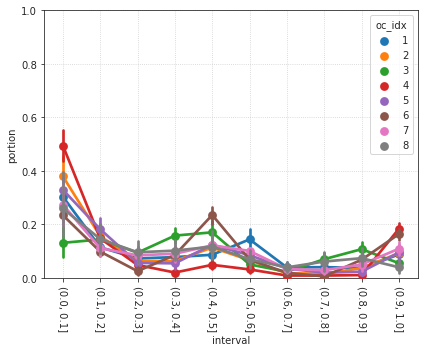

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93961695 0.91352349 0.85549439 0.95641106 0.92655307 0.72209459
 0.92145369 0.85346909 0.6287323 ] [0.96245296 0.97770864 0.92725906 0.98903582 0.97653674 
0.93150004
 0.99250247 0.96419999 0.82296913]

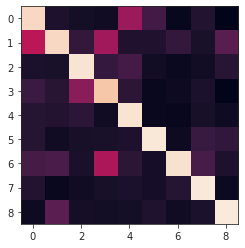

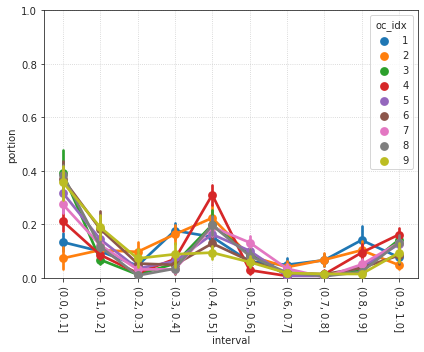

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.94240067 0.94617912 0.92750583 0.98636794 0.90143951 0.93451576
 0.87389807 0.86321784 0.55000391] [0.98222064 0.98591305 0.99390973 0.99631862 0.95085231 
0.93516495
 0.97306887 0.98986309 0.54986905]

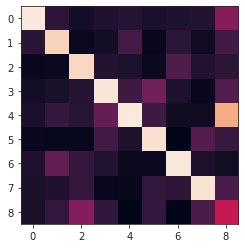

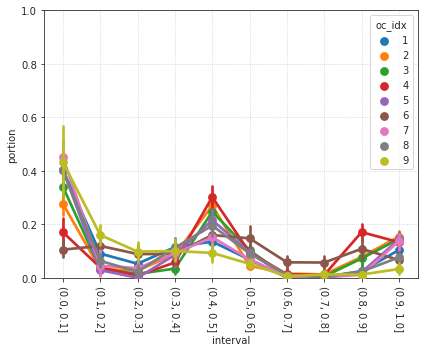

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.8936936  0.94379401 0.96909064 0.88953425 0.87067981 0.95985492
 0.58505506] [0.92057893 0.98800861 0.9836611  0.91123391 0.92657325 0.98698887
 0.59043096]

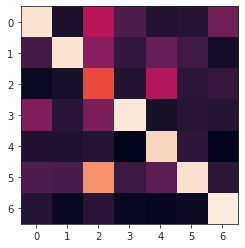

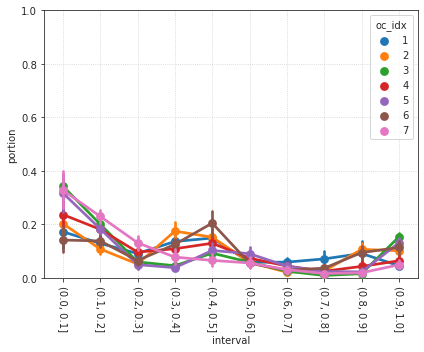

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92805059 0.87031898 0.91142935 0.84906391 0.90658956 0.77770064
 0.7295625  0.58887751] [0.96315402 0.89921573 0.93693804 0.91165249 0.97476776 0.81605677
 0.91059128 0.61065092]

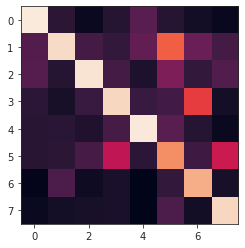

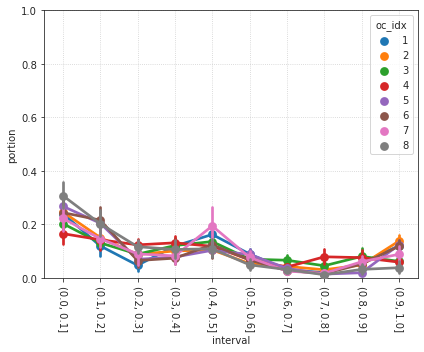

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.86982287 0.93759441 0.96049964 0.97580009 0.94466009 0.83621972
 0.78223945 0.51521419] [0.9258868  0.98307112 0.98953033 0.99543979 0.99110139 0.91340353
 0.84932183 0.46543608]

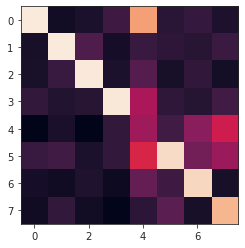

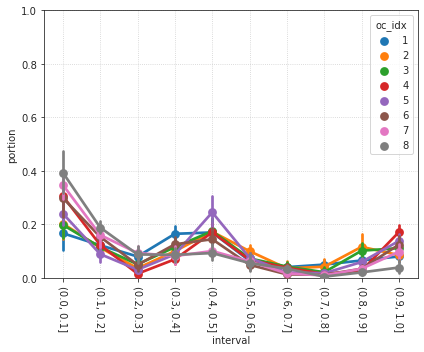

In [16]:
on = 69
om = 2 # 5
name = [
    f"on{on}",
    f"om{om}",
    f"mu{mu}",
]
name = '-'.join(name)

num_nodes = 138
num_cuts = 10
bins = np.linspace(0.0, 1.0, num_cuts + 1)
intervals = pd.cut([], bins).value_counts().index

for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        path = pjoin(lfr_dir, 'results', f"{name}_{key}")
        _lfr = load_lfr(
            load_dir=path,
            weighted=False,
            hierarchical=False,
            random_state=mice.cfg.random_state,
            verbose=False,
        )
        true_k = len(_lfr['community'])

        runs = next(os.walk(path))[1]
        runs = sorted(runs, key=seed_sort_fn)
        _runs = {}
        for run_name in runs:
            if f"k{true_k}" not in run_name or 'linksampling' not in run_name:
                continue
            num_nodes = re.sub(r"\D", "", run_name.split('-')[0])
            num_nodes = int(num_nodes)
            try:
                _runs[run_name] = load_svinet_runs(
                    path=pjoin(path, run_name),
                    true_nodes=range(1, num_nodes + 1),
                )
            except FileNotFoundError:
                continue
                
        pi_synth = np.zeros((len(_runs), true_k, num_nodes))
        for i, run in enumerate(_runs.values()):
            try:
                pi_synth[i] = run['pi']
            except ValueError:
                pi_synth[i] = run['pi'][:true_k]

        centroids, _ = fit_kmeans(
            data=pi_synth.reshape(-1, num_nodes),
            n_clusters=true_k,
            match_metric='euclidean',
            random_state=mice.cfg.random_state,
            normalize=True,
            verbose=True,
        )
        perms = find_best_mappings(
            centroids=centroids,
            data={i: pi_synth[i] for i in range(len(pi_synth))},
            match_metric='cosine',
        )
        for i, mapping in perms.items():
            pi_synth[i] = pi_synth[i][list(mapping.values())]
        pi_synth_avg = pi_synth.mean(0)
        
        scores = np.zeros((len(_runs), true_k))
        for i in range(len(pi_synth)):
            d = sp_dist.cdist(pi_synth_avg, pi_synth[i], metric='cosine')
            scores[i] = np.diag(dist2sim(d))
        print('self scores:', scores.mean(0), np.median(scores, 0))
        
        
        true_pi = np.zeros((true_k, num_nodes))
        for comm_i, comm_list in _lfr['community'].items():
            true_pi[comm_i][comm_list] = 1.0

        d = sp_dist.cdist(true_pi, pi_synth_avg, metric='cosine')
        s = dist2sim(d)
        true_mapping = find_best_match(s)
        pi_synth_avg = pi_synth_avg[list(true_mapping.values())]
        s = s[:, list(true_mapping.values())]

        plt.imshow(s)
        plt.show()

        cut_oc = np.zeros((len(_runs), true_k, num_cuts))
        cut_nodes = np.empty((len(_runs), num_nodes, num_cuts))
        cut_nodes[:] = np.nan

        for i in range(len(_runs)):
            for j in range(true_k):
                _cut = pd.cut(
                    x=np.round(
                        a=pi_synth[i, j],
                        decimals=2,
                    ), bins=bins,
                ).value_counts()
                counts = _cut.values
                portions = [c / sum(counts) for c in counts]
                cut_oc[i, j] = portions

            for j in range(num_nodes):
                _cut = pd.cut(
                    x=np.round(
                        a=pi_synth[i, :, j],
                        decimals=2,
                    ), bins=bins,
                ).value_counts()
                counts = _cut.values
                portions = [c / sum(counts) for c in counts]
                cut_nodes[i, j] = portions

        dlist = []
        for i in range(true_k):
            for j, intvl in enumerate(intervals):
                dlist.append({
                    'oc_idx': [i + 1] * len(cut_oc),
                    'interval': [intvl] * len(cut_oc),
                    'portion': cut_oc[:, i, j],
                })

        fig, ax = create_figure(1, 1, (6, 5))
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.pointplot(
            data=_df,
            x='interval',
            y='portion',
            hue='oc_idx',
            ax=ax,
        )
        ax.tick_params(axis='x', rotation=-90)
        ax.set_ylim(0, 1)
        ax.grid()
        plt.show()

In [19]:
num_cuts = 4
bins = np.linspace(0.2, 1.0, num_cuts + 1)
intervals = pd.cut([], bins).value_counts().index
bins

array([0.2, 0.4, 0.6, 0.8, 1. ])

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.90928903 0.92990253 0.98067461 0.97977179 0.96993086 0.92696345
 0.73474289 0.85829982] [0.94622398 0.99239127 0.99394049 0.99658777 0.99444519 0.98318481
 0.97664027 0.98505021]

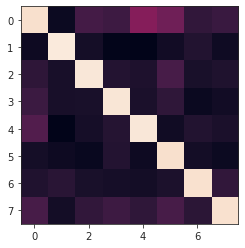

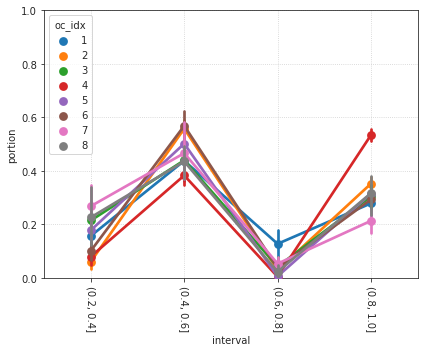

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93633495 0.94004032 0.99448474 0.99215361 0.78618429 0.9290675
 0.90430341 0.79140873 0.72523469] [0.98788777 0.97953919 0.99692027 0.99569636 0.743368   
0.99444709
 0.98270564 0.99048118 0.96447724]

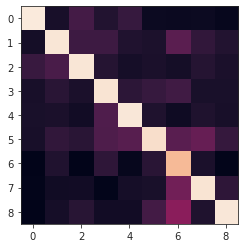

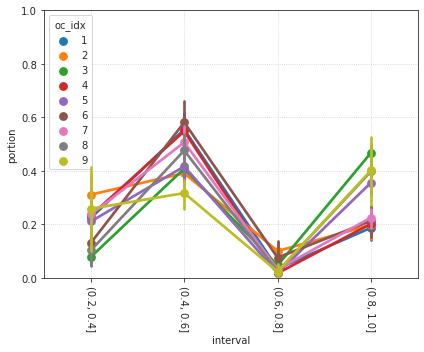

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.9916009  0.95399092 0.98221132 0.94655532 0.99273236 0.93198162
 0.64611133] [0.99554317 0.98390957 0.99591792 0.96578043 0.99744022 0.93725884
 0.639545  ]

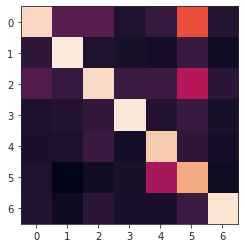

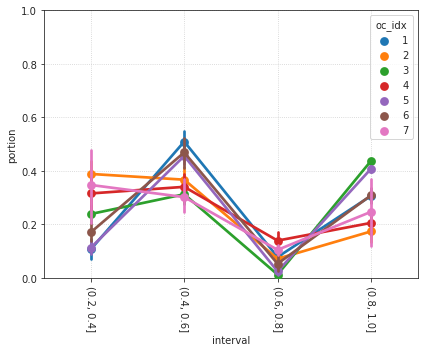

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96910311 0.95015222 0.91052797 0.8328588  0.8241972  0.94594571
 0.82877203 0.65100358] [0.99012105 0.98800668 0.94816767 0.8388937  0.94652405 0.97555671
 0.953575   0.88119252]

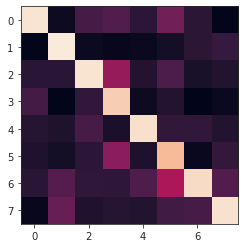

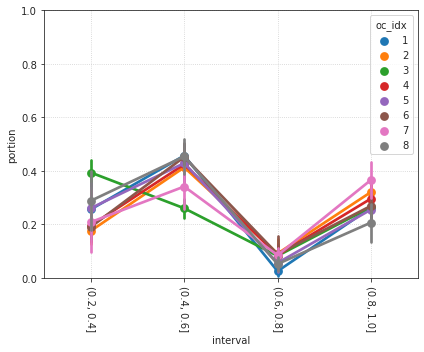

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98521539 0.98212317 0.99455465 0.98863207 0.97716173 0.99460219] [0.99633353 
0.99645946 0.99769172 0.99497101 0.99251099 0.99744986]

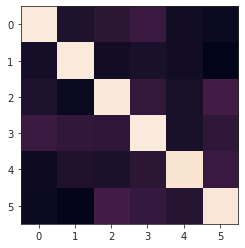

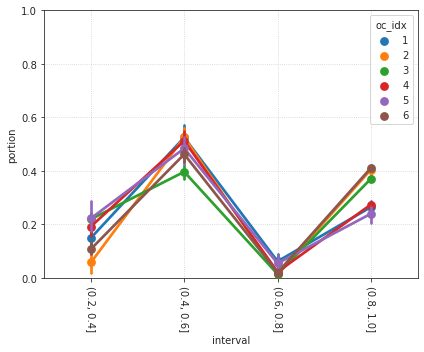

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92210704 0.83177285 0.89180732 0.84752369 0.97322173 0.90364943
 0.88161251 0.68097378 0.63875157] [0.92490226 0.85299537 0.98110047 0.97859689 0.97951012 
0.97701795
 0.98375644 0.89865168 0.95004713]

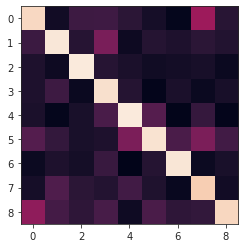

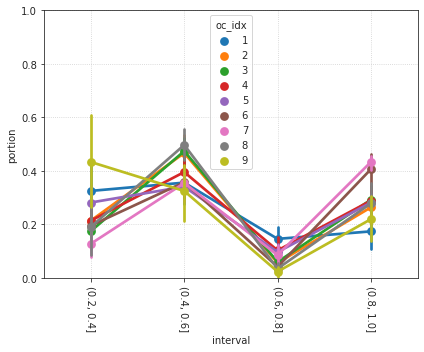

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.91502643 0.9323611  0.89945128 0.77886415 0.94287208 0.98690583
 0.81106867 0.67645874 0.61038158] [0.96513782 0.97019014 0.94510267 0.82699111 0.95819519 
0.99606434
 0.98701753 0.82639727 0.57883017]

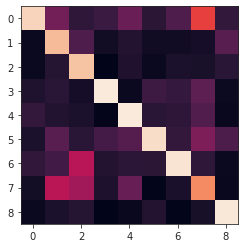

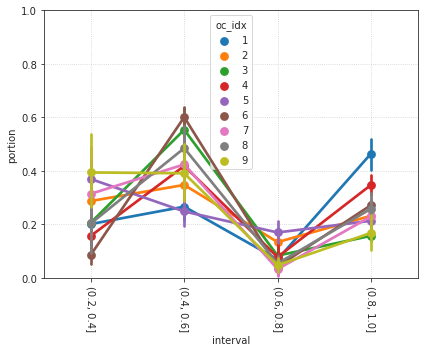

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98464786 0.83795232 0.81414208 0.97228041 0.98012778 0.92244986
 0.66867673] [0.9941458  0.82726727 0.92910771 0.98540146 0.98874589 0.9938252
 0.92904118]

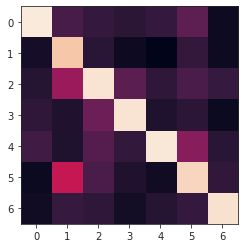

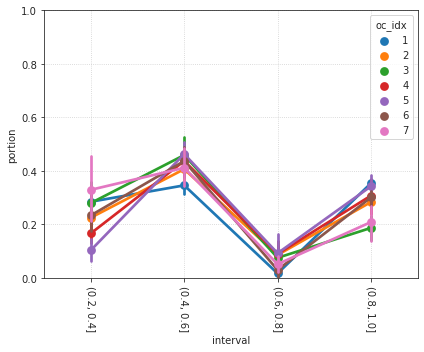

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.91857727 0.97391422 0.94522968 0.96326234 0.95898758 0.97299291
 0.84804061 0.68883091 0.78577632] [0.96757204 0.99780655 0.97150701 0.9884055  0.99135278 
0.98788614
 0.90111482 0.96856539 0.9747604 ]

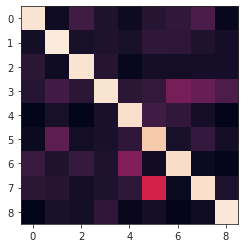

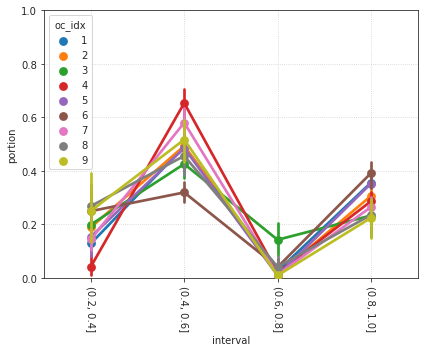

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98720993 0.96267157 0.95539619 0.95011895 0.98095766 0.96193336
 0.83876472 0.964813   0.96381886 0.84604115 0.45665784] [0.99758504 0.98891704 0.98324283 
0.9917138  0.99442806 0.99489176
 0.97165767 0.98874108 0.99626226 0.9424932  0.3153531 ]

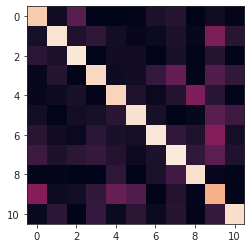

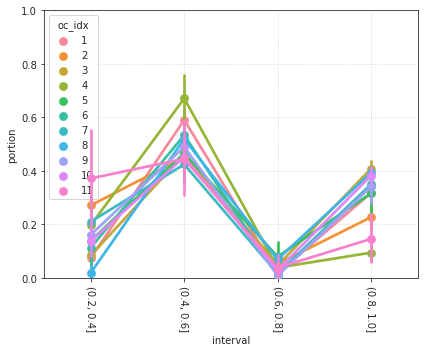

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.9469448  0.92056145 0.93310641 0.83380999 0.92283944 0.77488143
 0.60943093 0.99341717] [0.97573579 0.94334516 0.9838324  0.90941291 0.98593717 0.83129538
 0.63881657 0.99514063]

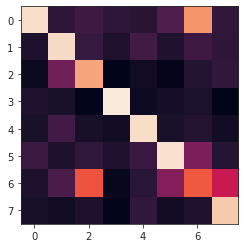

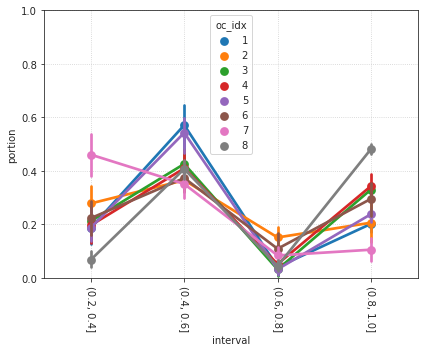

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96244845 0.93477641 0.94476649 0.99755884 0.88479454 0.98121535
 0.79912284] [0.99255082 0.98445372 0.99140882 0.99937467 0.9631257  0.9948841
 0.90319823]

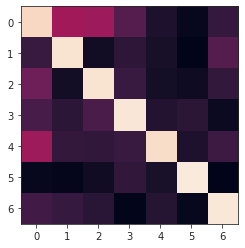

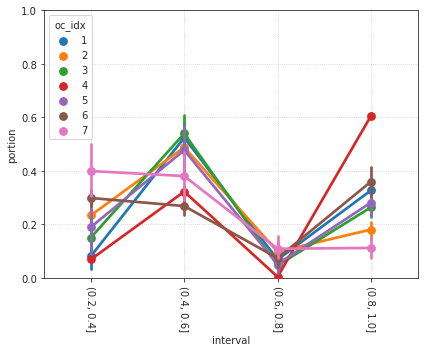

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93827292 0.89586758 0.91699627 0.95229581 0.71041504 0.62499023
 0.78747118] [0.94548035 0.91754857 0.9667154  0.98630194 0.86265349 0.66934006
 0.97321448]

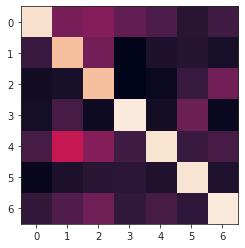

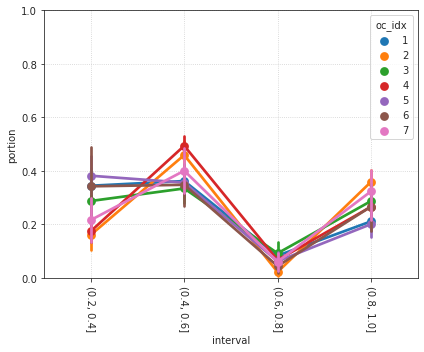

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.89571974 0.90025089 0.94417027 0.90243805 0.97348495 0.70905837
 0.62396666 0.65053931] [0.92646395 0.92644731 0.98102825 0.97348541 0.98942476 0.80182868
 0.83738319 0.87359791]

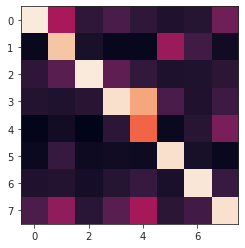

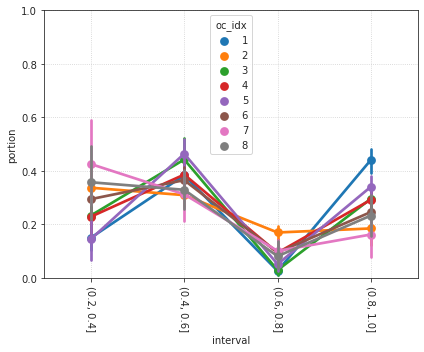

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.82930341 0.97804766 0.94827031 0.9174025  0.89781383 0.80777254
 0.64766225] [0.82448346 0.985945   0.98361801 0.97783082 0.92604833 0.93732591
 0.64609144]

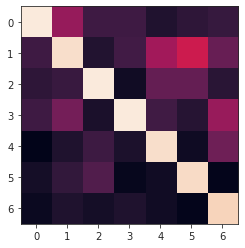

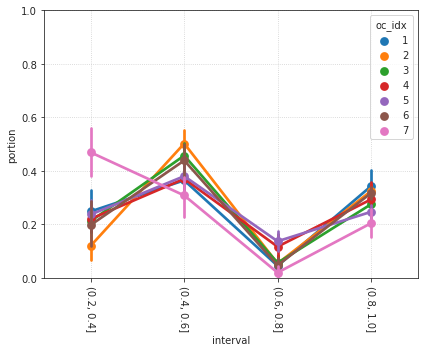

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.84905068 0.88970045 0.86029915 0.87290613 0.90244218 0.9277359
 0.6887055 ] [0.83654959 0.97230014 0.93567848 0.94850016 0.94325396 0.9910518
 0.92650571]

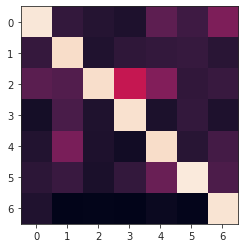

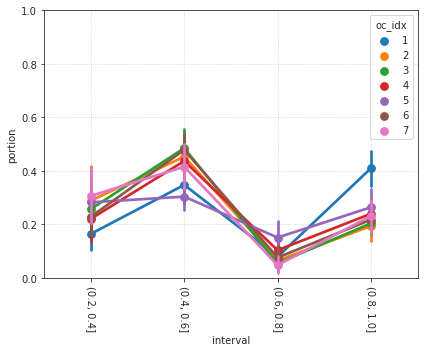

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96357389 0.90354614 0.96057599 0.81800916 0.99056432 0.81561324
 0.852735   0.6317824 ] [0.98959299 0.95799118 0.97143182 0.91743285 0.99748435 0.98806641
 0.95402369 0.79081153]

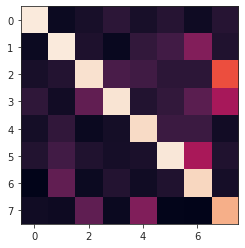

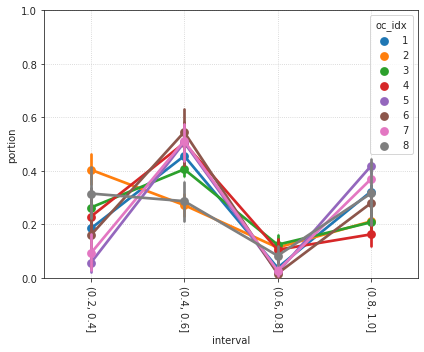

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93711205 0.96674349 0.91407612 0.76465579 0.96230672 0.64856014
 0.77006381 0.65740049] [0.98888034 0.98627847 0.93061532 0.81608838 0.98202044 0.87024072
 0.88797227 0.75621482]

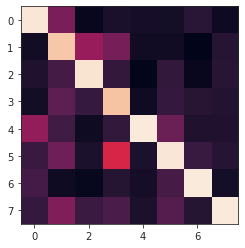

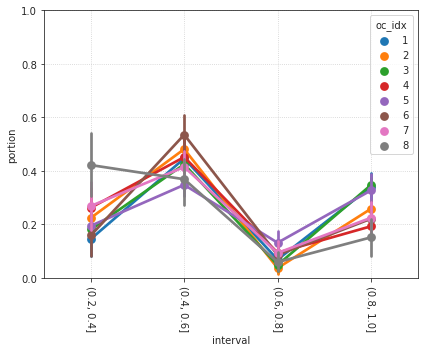

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.98822104 0.9165969  0.96319176 0.93158954 0.9935046  0.99489548
 0.98825191 0.79722532 0.74345433] [0.99413819 0.96504058 0.9889455  0.9961925  0.99831084 
0.99643225
 0.99602821 0.94228509 0.98726225]

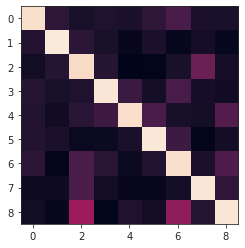

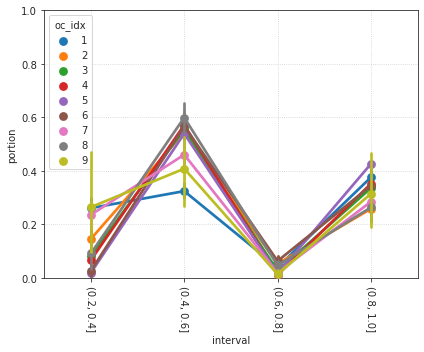

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92513489 0.97459727 0.99249702 0.99655322 0.97168091 0.6913314 ] [0.93546238 
0.99037429 0.99510443 0.9978438  0.98741225 0.93003501]

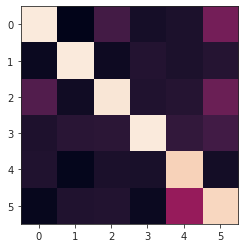

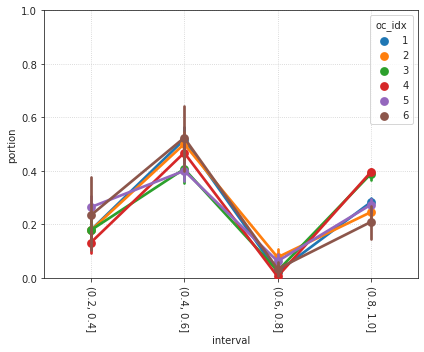

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.97313997 0.97617248 0.99360219 0.98656761 0.99173801 0.99806513
 0.94219802 0.84457699 0.74003635] [0.99482342 0.99104754 0.99694562 0.99738796 0.99576357 
0.99830825
 0.97035948 0.9610525  0.95652511]

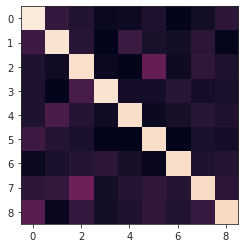

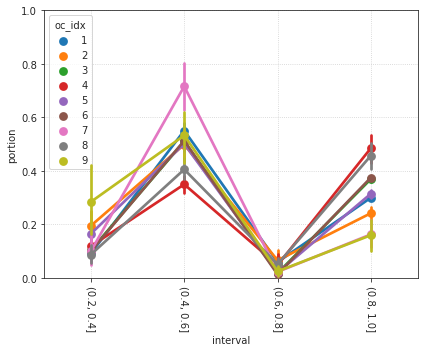

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.87051631 0.96269494 0.96206607 0.97807129 0.94087726 0.81459906
 0.88998847 0.99311924 0.6934108  0.56289958] [0.88403016 0.98380348 0.9930393  0.99626027 
0.97809832 0.88000655
 0.92960519 0.99785314 0.78988443 0.50216961]

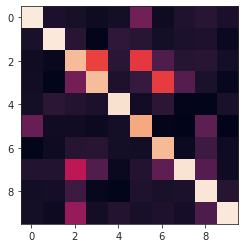

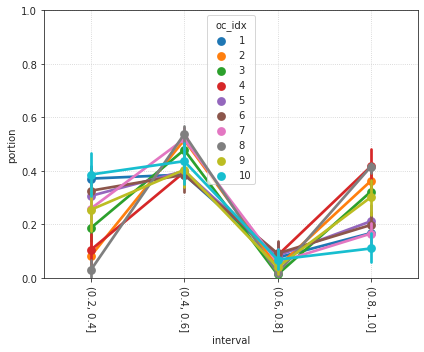

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.96504391 0.97097441 0.93251533 0.95395003 0.90968721 0.6362302 ] [0.98656614 
0.99376721 0.96483605 0.96973663 0.95857804 0.60729543]

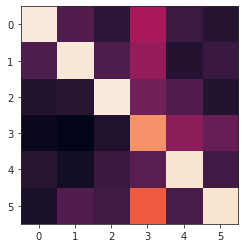

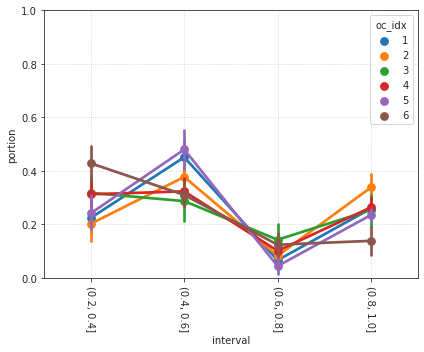

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.99157822 0.97226741 0.94626583 0.96713015 0.96459049 0.73185615
 0.83035709] [0.99744944 0.98569994 0.97015697 0.98969674 0.98362352 0.94069343
 0.9927293 ]

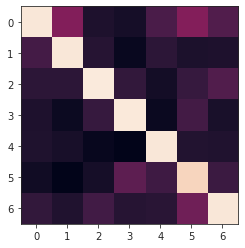

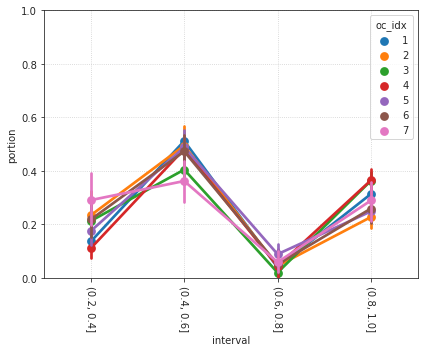

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92911645 0.902821   0.88231586 0.9800875  0.89952839 0.99312673
 0.89535595 0.67973944] [0.94417395 0.96434873 0.95869502 0.98558235 0.96866171 0.99703543
 0.9443616  0.90722622]

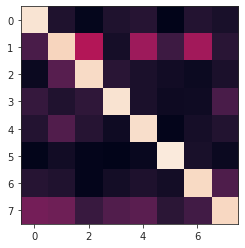

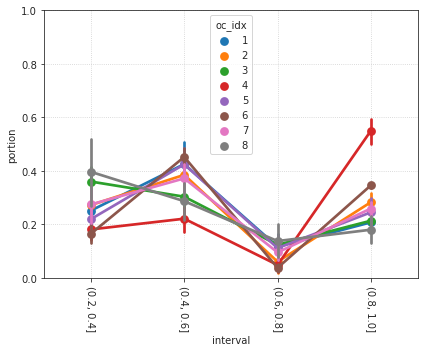

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.93961695 0.91352349 0.85549439 0.95641106 0.92655307 0.72209459
 0.92145369 0.85346909 0.6287323 ] [0.96245296 0.97770864 0.92725906 0.98903582 0.97653674 
0.93150004
 0.99250247 0.96419999 0.82296913]

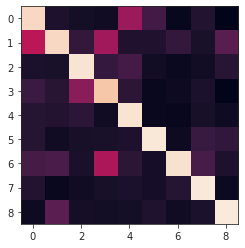

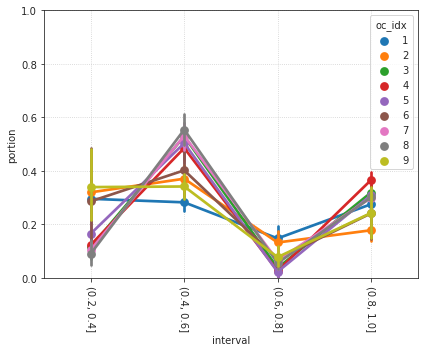

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.94240067 0.94617912 0.92750583 0.98636794 0.90143951 0.93451576
 0.87389807 0.86321784 0.55000391] [0.98222064 0.98591305 0.99390973 0.99631862 0.95085231 
0.93516495
 0.97306887 0.98986309 0.54986905]

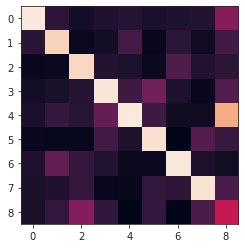

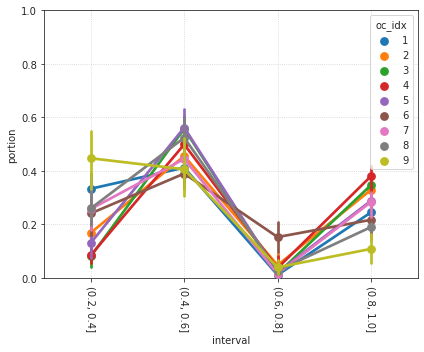

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.8936936  0.94379401 0.96909064 0.88953425 0.87067981 0.95985492
 0.58505506] [0.92057893 0.98800861 0.9836611  0.91123391 0.92657325 0.98698887
 0.59043096]

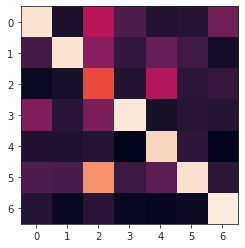

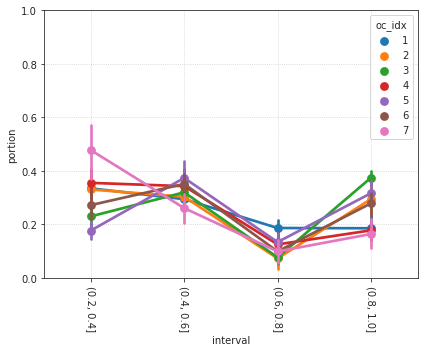

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.92805059 0.87031898 0.91142935 0.84906391 0.90658956 0.77770064
 0.7295625  0.58887751] [0.96315402 0.89921573 0.93693804 0.91165249 0.97476776 0.81605677
 0.91059128 0.61065092]

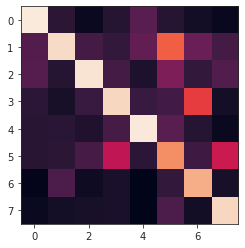

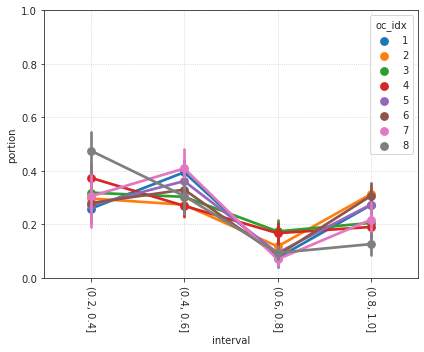

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

self scores: [0.86982287 0.93759441 0.96049964 0.97580009 0.94466009 0.83621972
 0.78223945 0.51521419] [0.9258868  0.98307112 0.98953033 0.99543979 0.99110139 0.91340353
 0.84932183 0.46543608]

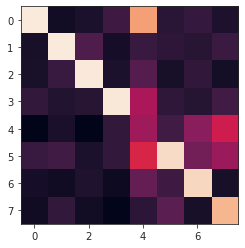

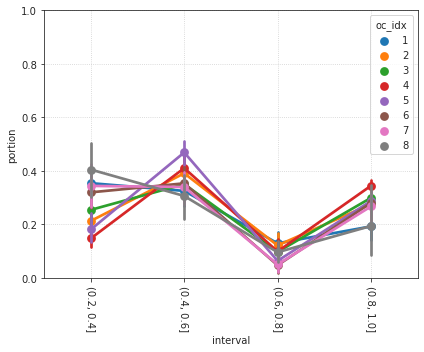

In [20]:
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        path = pjoin(lfr_dir, 'results', f"{name}_{key}")
        _lfr = load_lfr(
            load_dir=path,
            weighted=False,
            hierarchical=False,
            random_state=mice.cfg.random_state,
            verbose=False,
        )
        true_k = len(_lfr['community'])

        runs = next(os.walk(path))[1]
        runs = sorted(runs, key=seed_sort_fn)
        _runs = {}
        for run_name in runs:
            if f"k{true_k}" not in run_name or 'linksampling' not in run_name:
                continue
            num_nodes = re.sub(r"\D", "", run_name.split('-')[0])
            num_nodes = int(num_nodes)
            try:
                _runs[run_name] = load_svinet_runs(
                    path=pjoin(path, run_name),
                    true_nodes=range(1, num_nodes + 1),
                )
            except FileNotFoundError:
                continue
                
        pi_synth = np.zeros((len(_runs), true_k, num_nodes))
        for i, run in enumerate(_runs.values()):
            try:
                pi_synth[i] = run['pi']
            except ValueError:
                pi_synth[i] = run['pi'][:true_k]

        centroids, _ = fit_kmeans(
            data=pi_synth.reshape(-1, num_nodes),
            n_clusters=true_k,
            match_metric='euclidean',
            random_state=mice.cfg.random_state,
            normalize=True,
            verbose=True,
        )
        perms = find_best_mappings(
            centroids=centroids,
            data={i: pi_synth[i] for i in range(len(pi_synth))},
            match_metric='cosine',
        )
        for i, mapping in perms.items():
            pi_synth[i] = pi_synth[i][list(mapping.values())]
        pi_synth_avg = pi_synth.mean(0)
        
        scores = np.zeros((len(_runs), true_k))
        for i in range(len(pi_synth)):
            d = sp_dist.cdist(pi_synth_avg, pi_synth[i], metric='cosine')
            scores[i] = np.diag(dist2sim(d))
        print('self scores:', scores.mean(0), np.median(scores, 0))
        
        
        true_pi = np.zeros((true_k, num_nodes))
        for comm_i, comm_list in _lfr['community'].items():
            true_pi[comm_i][comm_list] = 1.0

        d = sp_dist.cdist(true_pi, pi_synth_avg, metric='cosine')
        s = dist2sim(d)
        true_mapping = find_best_match(s)
        pi_synth_avg = pi_synth_avg[list(true_mapping.values())]
        s = s[:, list(true_mapping.values())]

        plt.imshow(s)
        plt.show()

        cut_oc = np.zeros((len(_runs), true_k, num_cuts))
        cut_nodes = np.empty((len(_runs), num_nodes, num_cuts))
        cut_nodes[:] = np.nan

        for i in range(len(_runs)):
            for j in range(true_k):
                _cut = pd.cut(
                    x=np.round(
                        a=pi_synth[i, j],
                        decimals=2,
                    ), bins=bins,
                ).value_counts()
                counts = _cut.values
                portions = [c / sum(counts) for c in counts]
                cut_oc[i, j] = portions

            for j in range(num_nodes):
                _cut = pd.cut(
                    x=np.round(
                        a=pi_synth[i, :, j],
                        decimals=2,
                    ), bins=bins,
                ).value_counts()
                counts = _cut.values
                portions = [c / sum(counts) for c in counts]
                cut_nodes[i, j] = portions

        dlist = []
        for i in range(true_k):
            for j, intvl in enumerate(intervals):
                dlist.append({
                    'oc_idx': [i + 1] * len(cut_oc),
                    'interval': [intvl] * len(cut_oc),
                    'portion': cut_oc[:, i, j],
                })

        fig, ax = create_figure(1, 1, (6, 5))
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.pointplot(
            data=_df,
            x='interval',
            y='portion',
            hue='oc_idx',
            ax=ax,
        )
        ax.tick_params(axis='x', rotation=-90)
        ax.set_ylim(0, 1)
        ax.grid()
        plt.show()

In [22]:
138 / 3

0.2463768115942029

## ALl

In [505]:
num_nodes = 138
num_cuts = 4
bins = np.linspace(0.2, 1.0, num_cuts + 1)
intervals = pd.cut([], bins).value_counts().index

cut_oc_all = {}
cut_nodes_all = {}
for on, om in tqdm(zip(ons, oms)):
    name = [
        f"on{on}",
        f"om{om}",
        f"mu{mu}",
    ]
    name = '-'.join(name)
    for sub in mice.cfg.sub_ids:
        for ses in mice.cfg.ses_ids:
            key = mice.get_key(sub, ses)
            path = pjoin(lfr_dir, 'results', f"{name}_{key}")
            _lfr = load_lfr(
                load_dir=path,
                weighted=False,
                hierarchical=False,
                random_state=mice.cfg.random_state,
                verbose=False,
            )
            true_k = len(_lfr['community'])

            runs = next(os.walk(path))[1]
            runs = sorted(runs, key=seed_sort_fn)
            _runs = {}
            for run_name in runs:
                if f"k{true_k}" not in run_name or 'linksampling' not in run_name:
                    continue
                num_nodes = re.sub(r"\D", "", run_name.split('-')[0])
                num_nodes = int(num_nodes)
                try:
                    _runs[run_name] = load_svinet_runs(
                        path=pjoin(path, run_name),
                        true_nodes=range(1, num_nodes + 1),
                    )
                except FileNotFoundError:
                    continue

            pi_synth = np.zeros((len(_runs), true_k, num_nodes))
            for i, run in enumerate(_runs.values()):
                try:
                    pi_synth[i] = run['pi']
                except ValueError:
                    pi_synth[i] = run['pi'][:true_k]

            centroids, _ = fit_kmeans(
                data=pi_synth.reshape(-1, num_nodes),
                n_clusters=true_k,
                match_metric='euclidean',
                random_state=mice.cfg.random_state,
                normalize=True,
                verbose=True,
            )
            perms = find_best_mappings(
                centroids=centroids,
                data={i: pi_synth[i] for i in range(len(pi_synth))},
                match_metric='cosine',
            )
            for i, mapping in perms.items():
                pi_synth[i] = pi_synth[i][list(mapping.values())]
            pi_synth_avg = pi_synth.mean(0)

            true_pi = np.zeros((true_k, num_nodes))
            for comm_i, comm_list in _lfr['community'].items():
                true_pi[comm_i][comm_list] = 1.0
            d = sp_dist.cdist(true_pi, pi_synth_avg, metric='cosine')
            s = dist2sim(d)
            true_mapping = find_best_match(s)
            pi_synth_avg = pi_synth_avg[list(true_mapping.values())]

            cut_oc = np.zeros((len(_runs), true_k, num_cuts))
            cut_nodes = np.empty((len(_runs), num_nodes, num_cuts))
            cut_nodes[:] = np.nan

            for i in range(len(_runs)):
                for j in range(true_k):
                    _cut = pd.cut(
                        x=np.round(
                            a=pi_synth[i, j],
                            decimals=2,
                        ), bins=bins,
                    ).value_counts()
                    counts = _cut.values
                    portions = [c / sum(counts) for c in counts]
                    cut_oc[i, j] = portions

                for j in range(num_nodes):
                    _cut = pd.cut(
                        x=np.round(
                            a=pi_synth[i, :, j],
                            decimals=2,
                        ), bins=bins,
                    ).value_counts()
                    counts = _cut.values
                    portions = [c / sum(counts) for c in counts]
                    cut_nodes[i, j] = portions
                    
            cut_oc_all[f"{name}_{key}"] = cut_oc
            cut_nodes_all[f"{name}_{key}"] = cut_nodes

0it [00:00, ?it/s]

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

In [506]:
list(cut_nodes_all)

[
    'on0-om0-mu0.1_sub-SLC01_ses-1',
    'on0-om0-mu0.1_sub-SLC01_ses-2',
    'on0-om0-mu0.1_sub-SLC01_ses-3',
    'on0-om0-mu0.1_sub-SLC02_ses-1',
    'on0-om0-mu0.1_sub-SLC02_ses-2',
    'on0-om0-mu0.1_sub-SLC02_ses-3',
    'on0-om0-mu0.1_sub-SLC03_ses-1',
    'on0-om0-mu0.1_sub-SLC03_ses-2',
    'on0-om0-mu0.1_sub-SLC03_ses-3',
    'on0-om0-mu0.1_sub-SLC04_ses-1',
    'on0-om0-mu0.1_sub-SLC04_ses-2',
    'on0-om0-mu0.1_sub-SLC04_ses-3',
    'on0-om0-mu0.1_sub-SLC05_ses-1',
    'on0-om0-mu0.1_sub-SLC05_ses-2',
    'on0-om0-mu0.1_sub-SLC05_ses-3',
    'on0-om0-mu0.1_sub-SLC06_ses-1',
    'on0-om0-mu0.1_sub-SLC06_ses-2',
    'on0-om0-mu0.1_sub-SLC06_ses-3',
    'on0-om0-mu0.1_sub-SLC07_ses-1',
    'on0-om0-mu0.1_sub-SLC07_ses-2',
    'on0-om0-mu0.1_sub-SLC07_ses-3',
    'on0-om0-mu0.1_sub-SLC08_ses-1',
    'on0-om0-mu0.1_sub-SLC08_ses-2',
    'on0-om0-mu0.1_sub-SLC08_ses-3',
    'on0-om0-mu0.1_sub-SLC09_ses-1',
    'on0-om0-mu0.1_sub-SLC09_ses-2',
    'on0-om0-mu0.1_sub-SLC09_ses-3',
    'on0-om0-mu0.1_sub-SLC10_ses-1',
    'on0-om0-mu0.1_sub-SLC10_ses-2',
    'on0-om0-mu0.1_sub-SLC10_ses-3',
    'on34-om2-mu0.1_sub-SLC01_ses-1',
    'on34-om2-mu0.1_sub-SLC01_ses-2',
    'on34-om2-mu0.1_sub-SLC01_ses-3',
    'on34-om2-mu0.1_sub-SLC02_ses-1',
    'on34-om2-mu0.1_sub-SLC02_ses-2',
    'on34-om2-mu0.1_sub-SLC02_ses-3',
    'on34-om2-mu0.1_sub-SLC03_ses-1',
    'on34-om2-mu0.1_sub-SLC03_ses-2',
    'on34-om2-mu0.1_sub-SLC03_ses-3',
    'on34-om2-mu0.1_sub-SLC04_ses-1',
    'on34-om2-mu0.1_sub-SLC04_ses-2',
    'on34-om2-mu0.1_sub-SLC04_ses-3',
    'on34-om2-mu0.1_sub-SLC05_ses-1',
    'on34-om2-mu0.1_sub-SLC05_ses-2',
    'on34-om2-mu0.1_sub-SLC05_ses-3',
    'on34-om2-mu0.1_sub-SLC06_ses-1',
    'on34-om2-mu0.1_sub-SLC06_ses-2',
    'on34-om2-mu0.1_sub-SLC06_ses-3',
    'on34-om2-mu0.1_sub-SLC07_ses-1',
    'on34-om2-mu0.1_sub-SLC07_ses-2',
    'on34-om2-mu0.1_sub-SLC07_ses-3',
    'on34-om2-mu0.1_sub-SLC08_ses-1',
    'on34-om2-mu0.1_sub-SLC08_ses-2',
    'on34-om2-mu0.1_sub-SLC08_ses-3',
    'on34-om2-mu0.1_sub-SLC09_ses-1',
    'on34-om2-mu0.1_sub-SLC09_ses-2',
    'on34-om2-mu0.1_sub-SLC09_ses-3',
    'on34-om2-mu0.1_sub-SLC10_ses-1',
    'on34-om2-mu0.1_sub-SLC10_ses-2',
    'on34-om2-mu0.1_sub-SLC10_ses-3',
    'on34-om4-mu0.1_sub-SLC01_ses-1',
    'on34-om4-mu0.1_sub-SLC01_ses-2',
    'on34-om4-mu0.1_sub-SLC01_ses-3',
    'on34-om4-mu0.1_sub-SLC02_ses-1',
    'on34-om4-mu0.1_sub-SLC02_ses-2',
    'on34-om4-mu0.1_sub-SLC02_ses-3',
    'on34-om4-mu0.1_sub-SLC03_ses-1',
    'on34-om4-mu0.1_sub-SLC03_ses-2',
    'on34-om4-mu0.1_sub-SLC03_ses-3',
    'on34-om4-mu0.1_sub-SLC04_ses-1',
    'on34-om4-mu0.1_sub-SLC04_ses-2',
    'on34-om4-mu0.1_sub-SLC04_ses-3',
    'on34-om4-mu0.1_sub-SLC05_ses-1',
    'on34-om4-mu0.1_sub-SLC05_ses-2',
    'on34-om4-mu0.1_sub-SLC05_ses-3',
    'on34-om4-mu0.1_sub-SLC06_ses-1',
    'on34-om4-mu0.1_sub-SLC06_ses-2',
    'on34-om4-mu0.1_sub-SLC06_ses-3',
    'on34-om4-mu0.1_sub-SLC07_ses-1',
    'on34-om4-mu0.1_sub-SLC07_ses-2',
    'on34-om4-mu0.1_sub-SLC07_ses-3',
    'on34-om4-mu0.1_sub-SLC08_ses-1',
    'on34-om4-mu0.1_sub-SLC08_ses-2',
    'on34-om4-mu0.1_sub-SLC08_ses-3',
    'on34-om4-mu0.1_sub-SLC09_ses-1',
    'on34-om4-mu0.1_sub-SLC09_ses-2',
    'on34-om4-mu0.1_sub-SLC09_ses-3',
    'on34-om4-mu0.1_sub-SLC10_ses-1',
    'on34-om4-mu0.1_sub-SLC10_ses-2',
    'on34-om4-mu0.1_sub-SLC10_ses-3',
    'on69-om2-mu0.1_sub-SLC01_ses-1',
    'on69-om2-mu0.1_sub-SLC01_ses-2',
    'on69-om2-mu0.1_sub-SLC01_ses-3',
    'on69-om2-mu0.1_sub-SLC02_ses-1',
    'on69-om2-mu0.1_sub-SLC02_ses-2',
    'on69-om2-mu0.1_sub-SLC02_ses-3',
    'on69-om2-mu0.1_sub-SLC03_ses-1',
    'on69-om2-mu0.1_sub-SLC03_ses-2',
    'on69-om2-mu0.1_sub-SLC03_ses-3',
    'on69-om2-mu0.1_sub-SLC04_ses-1',
    'on69-om2-mu0.1_sub-SLC04_ses-2',
    'on69-om2-mu0.1_sub-SLC04_ses-3',
    'on69-om2-mu0.1_sub-SLC05_ses-1',
    'on69-om2-mu0.1_sub-SLC05_ses-2',
    'on69-om2-mu0.1_sub-SLC05_ses-3',
    'on69-om2-mu0.1_sub-SLC06_ses-1',


In [511]:
cut_nodes_all['on0-om0-mu0.1_sub-SLC02_ses-1'].shape

(13, 138, 4)

In [527]:
s = 'on0-om0-mu0.1_sub-SLC02_ses-1'


'sub-SLC02_ses-1'

In [524]:
list()

[
    'on103-om7-mu0.1_sub-SLC01_ses-1',
    'on103-om7-mu0.1_sub-SLC01_ses-2',
    'on103-om7-mu0.1_sub-SLC01_ses-3',
    'on103-om7-mu0.1_sub-SLC02_ses-1',
    'on103-om7-mu0.1_sub-SLC02_ses-2',
    'on103-om7-mu0.1_sub-SLC02_ses-3',
    'on103-om7-mu0.1_sub-SLC03_ses-1',
    'on103-om7-mu0.1_sub-SLC03_ses-2',
    'on103-om7-mu0.1_sub-SLC03_ses-3',
    'on103-om7-mu0.1_sub-SLC04_ses-1',
    'on103-om7-mu0.1_sub-SLC04_ses-2',
    'on103-om7-mu0.1_sub-SLC04_ses-3',
    'on103-om7-mu0.1_sub-SLC05_ses-1',
    'on103-om7-mu0.1_sub-SLC05_ses-2',
    'on103-om7-mu0.1_sub-SLC05_ses-3',
    'on103-om7-mu0.1_sub-SLC06_ses-1',
    'on103-om7-mu0.1_sub-SLC06_ses-2',
    'on103-om7-mu0.1_sub-SLC06_ses-3',
    'on103-om7-mu0.1_sub-SLC07_ses-1',
    'on103-om7-mu0.1_sub-SLC07_ses-2',
    'on103-om7-mu0.1_sub-SLC07_ses-3',
    'on103-om7-mu0.1_sub-SLC08_ses-1',
    'on103-om7-mu0.1_sub-SLC08_ses-2',
    'on103-om7-mu0.1_sub-SLC08_ses-3',
    'on103-om7-mu0.1_sub-SLC09_ses-1',
    'on103-om7-mu0.1_sub-SLC09_ses-2',
    'on103-om7-mu0.1_sub-SLC09_ses-3',
    'on103-om7-mu0.1_sub-SLC10_ses-1',
    'on103-om7-mu0.1_sub-SLC10_ses-2',
    'on103-om7-mu0.1_sub-SLC10_ses-3'
]

In [531]:
dlist = []
for on, om in zip(ons, oms):
    name = [
        f"on{on}",
        f"om{om}",
        f"mu{mu}",
    ]
    name = '-'.join(name)
    for item in filter(lambda e: name in e, cut_nodes_all):
        key = '_'.join(item.split('_')[1:])
        for j, intvl in enumerate(intervals):
            data = cut_nodes_all[item][..., j].ravel()
            dlist.append({
                'on': [on] * len(data),
                'om': [om] * len(data),
                'key': [key] * len(data),
                'interval': [intvl] * len(data),
                'portion': data,
            })
_df = pd.DataFrame(merge_dicts(dlist))

In [533]:
item, key

('on103-om7-mu0.1_sub-SLC10_ses-3', 'sub-SLC10_ses-3')

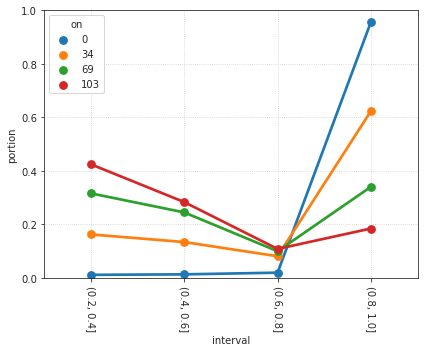

In [534]:
fig, ax = create_figure(1, 1, (6, 5))

sns.pointplot(
    data=_df,
    x='interval',
    y='portion',
    hue='on',
    ax=ax,
)
ax.tick_params(axis='x', rotation=-90)
ax.set_ylim(0, 1)
ax.grid()
plt.show()

In [515]:
cut_nodes_all['on0-om0-mu0.1_sub-SLC02_ses-1'].mean(0)

array([[0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.07692308, 0.92307692],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.03846154, 0.        , 0.03846154, 0.92307692],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.